In [1]:
import pandas as pd
from pandas import DataFrame as dframe
import pymc as pm
import arviz as az
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import choice
from pytensor import shared
from autograd import grad, jacobian

import utils
from utils import dotdict
from utils.algos import pyquap 
from utils.data import data
from utils.analysis import * # precis, cov2cor
from utils.stats import * # r::stats functions (rnorm, dnorm, ...)
from utils.plots import init_dag, scatter
utils.init() # init plotting styles and hush warnings
np.random.seed(8964) # seed

# Chapter 4 Geocentric Models

Claudius Ptolemy built some extremely accurate model for planet motions. The model is basically circles on circles on circles. With enough circles, he could accurately predict the location of a celestial body in the sky. But the model is simply wrong, although in some narrow domain of query it provides accurate answers. This modeling strategy is the same as a Fourier series.

## Keywords
Prior predictive simulation, grid approximation, quadratic approximation, plausibility intervals, p-hacking, bayesian model interpretation, meaning of parameters.



---
## Section 4.1. Why normal distributions are normal

Consider the Galton's board as an example. McElreath gave a random walk example similar to that. Let's simulate that here. Say 1000 people were to do random walks from the left end of the yard to the right end. And it takes 16 steps. At each left-to-right step, each person either goes up or down by a number between -1 and 1 also.

Learning outcomes:
- 4.1.1 - 4.1.3: when normality comes
- 4.1.4: justifications of using normal distributions

### Code 4.1 (random walks)

In [56]:
random_walks = np.hstack([np.zeros((1000, 1)), runif((1000, 16), -1, 1)]).cumsum(1)
df_random_walks = dframe(random_walks).T
df_random_walks.columns = "s" + df_random_walks.columns.astype(str)
df_random_walks["step"] = np.arange(17)
df_random_walks = df_random_walks.melt(id_vars=["step"], value_vars=df_random_walks.columns, value_name="position")

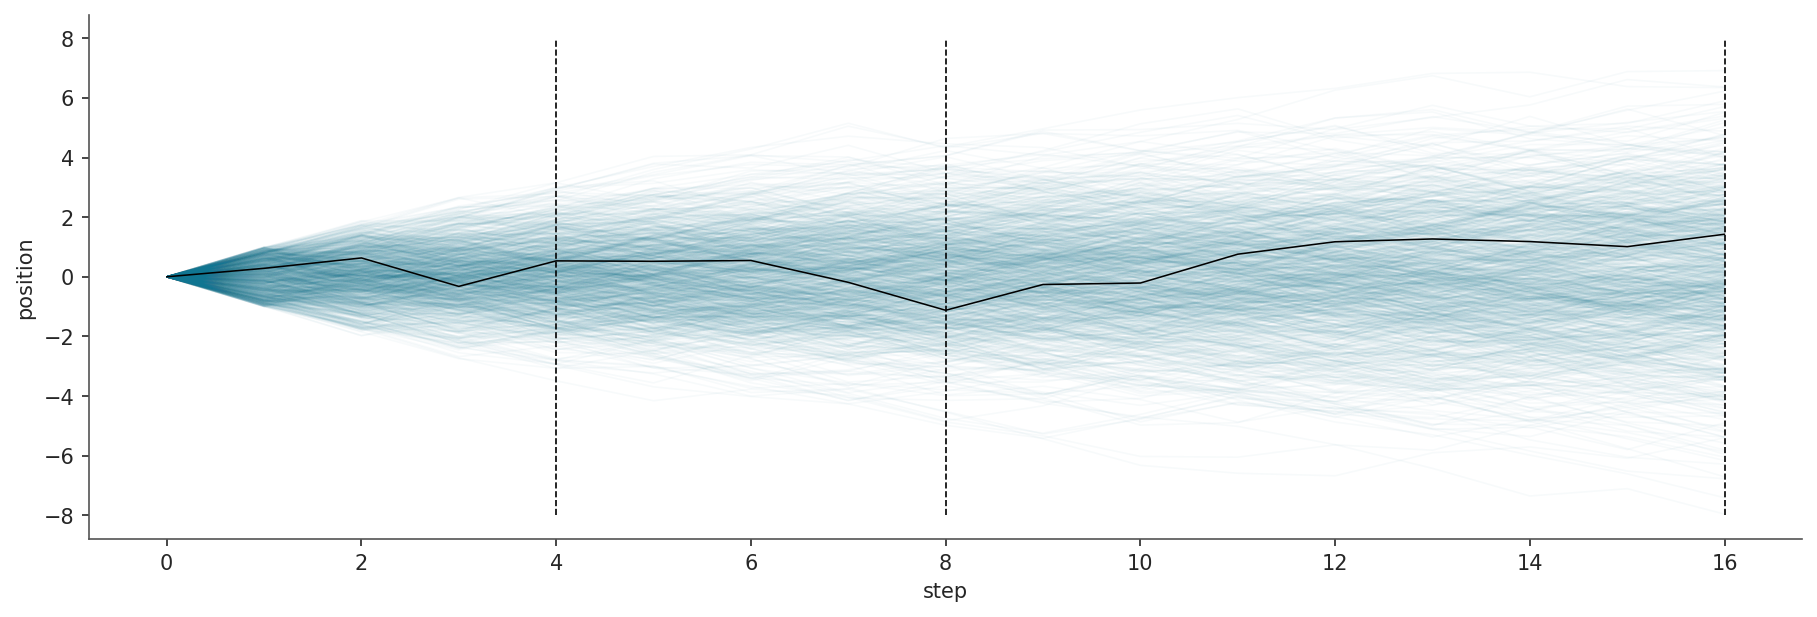

In [57]:
_, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=df_random_walks, x="step", y="position", units="variable", estimator=None, alpha=0.03, ax=ax)
sns.lineplot(data=df_random_walks[df_random_walks.variable == "s0"], x="step", y="position", ax=ax, color="k", linewidth=0.75)
ax.vlines(x=[4, 8, 16], ymin=-8, ymax=8, color="k", linestyles="dashed", linewidth=0.8);

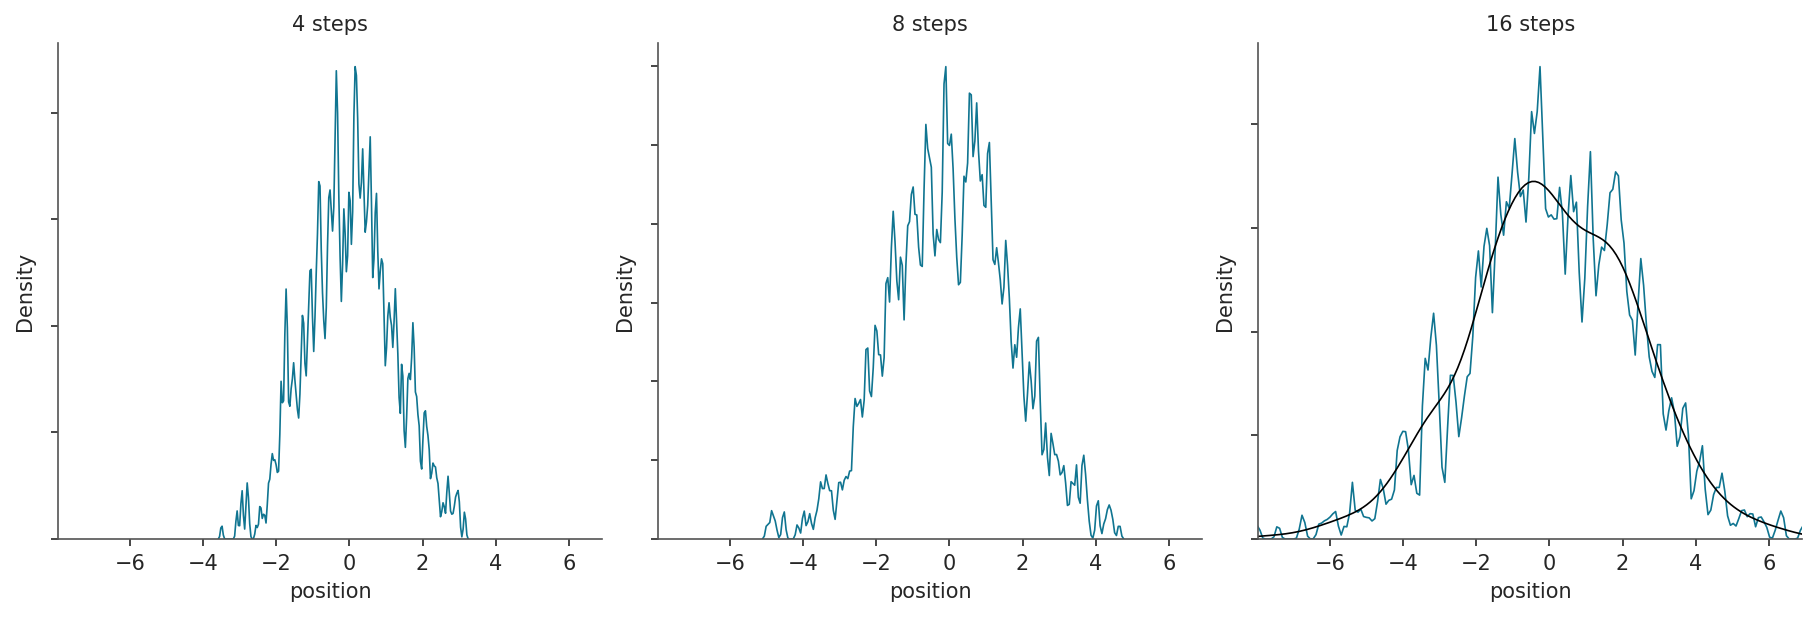

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.kdeplot(random_walks[:, 4], bw_adjust=.1, ax=ax[0])
sns.kdeplot(random_walks[:, 8], bw_adjust=.1, ax=ax[1])
sns.kdeplot(random_walks[:, 16], bw_adjust=.1, ax=ax[2])
sns.kdeplot(random_walks[:, 16], color="k", ax=ax[2])
ax[0].set(title="4 steps")
ax[1].set(title="8 steps")
ax[2].set(title="16 steps")
plt.setp(ax, xlabel="position", xlim=[random_walks.min(), random_walks.max()], yticklabels=[]);

If you add together independent random values from the same distribution, you always get a normal random variable. The underlying distribution of each value can be nearly anything, but the convergence will happen, sometimes slowly. 

### Code 4.2 (normality by multiplication)

Here's another to get a normal distribution.

In [59]:
runif(12, 1, 1.1).cumprod()

array([1.08641673, 1.1105451 , 1.18850237, 1.20851164, 1.21742181,
       1.30875669, 1.41521665, 1.51804709, 1.59730216, 1.70972657,
       1.75503133, 1.78006108])

### Code 4.3 (cont'd)

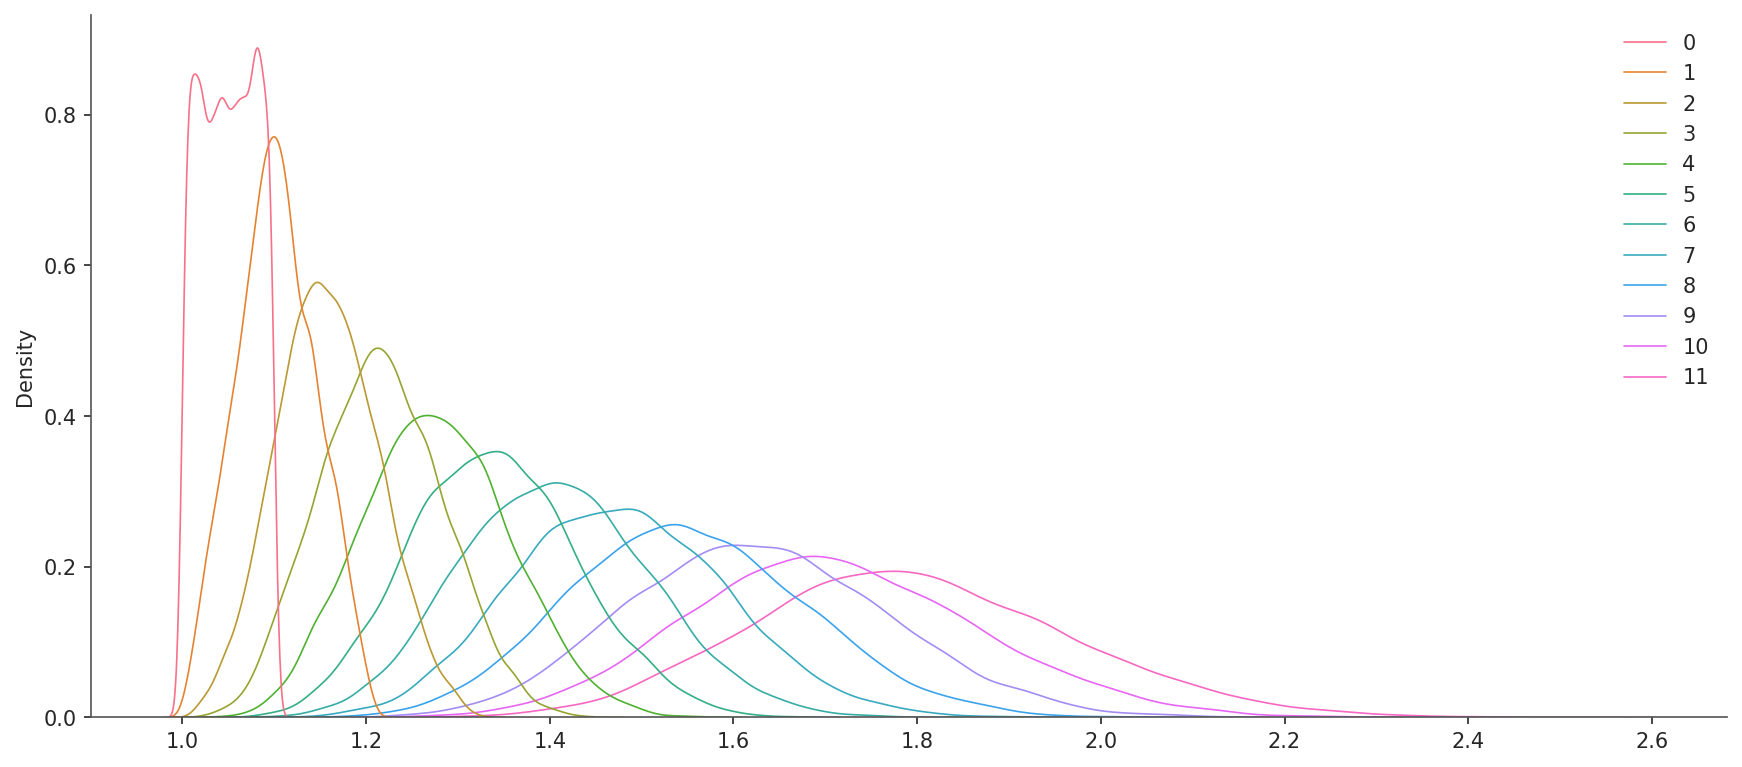

In [60]:
growth = runif((int(1e4), 12), 1, 1.1).cumprod(1)
sns.kdeplot(growth);

### Code 4.4 (cont'd)

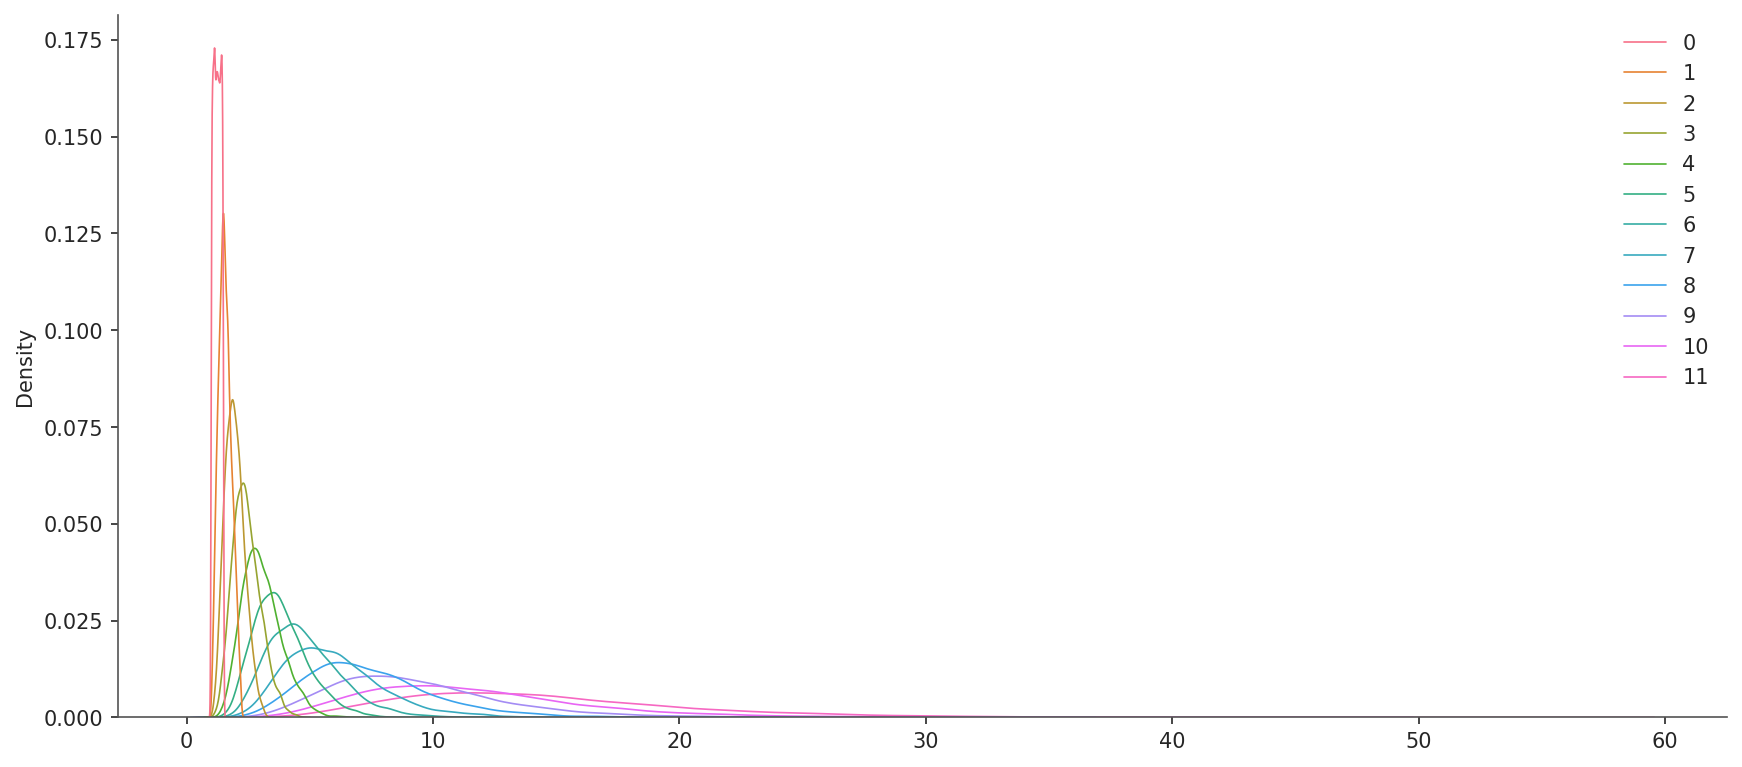

In [61]:
growth = runif((int(1e4), 12), 1, 1.5).cumprod(1)
sns.kdeplot(growth);

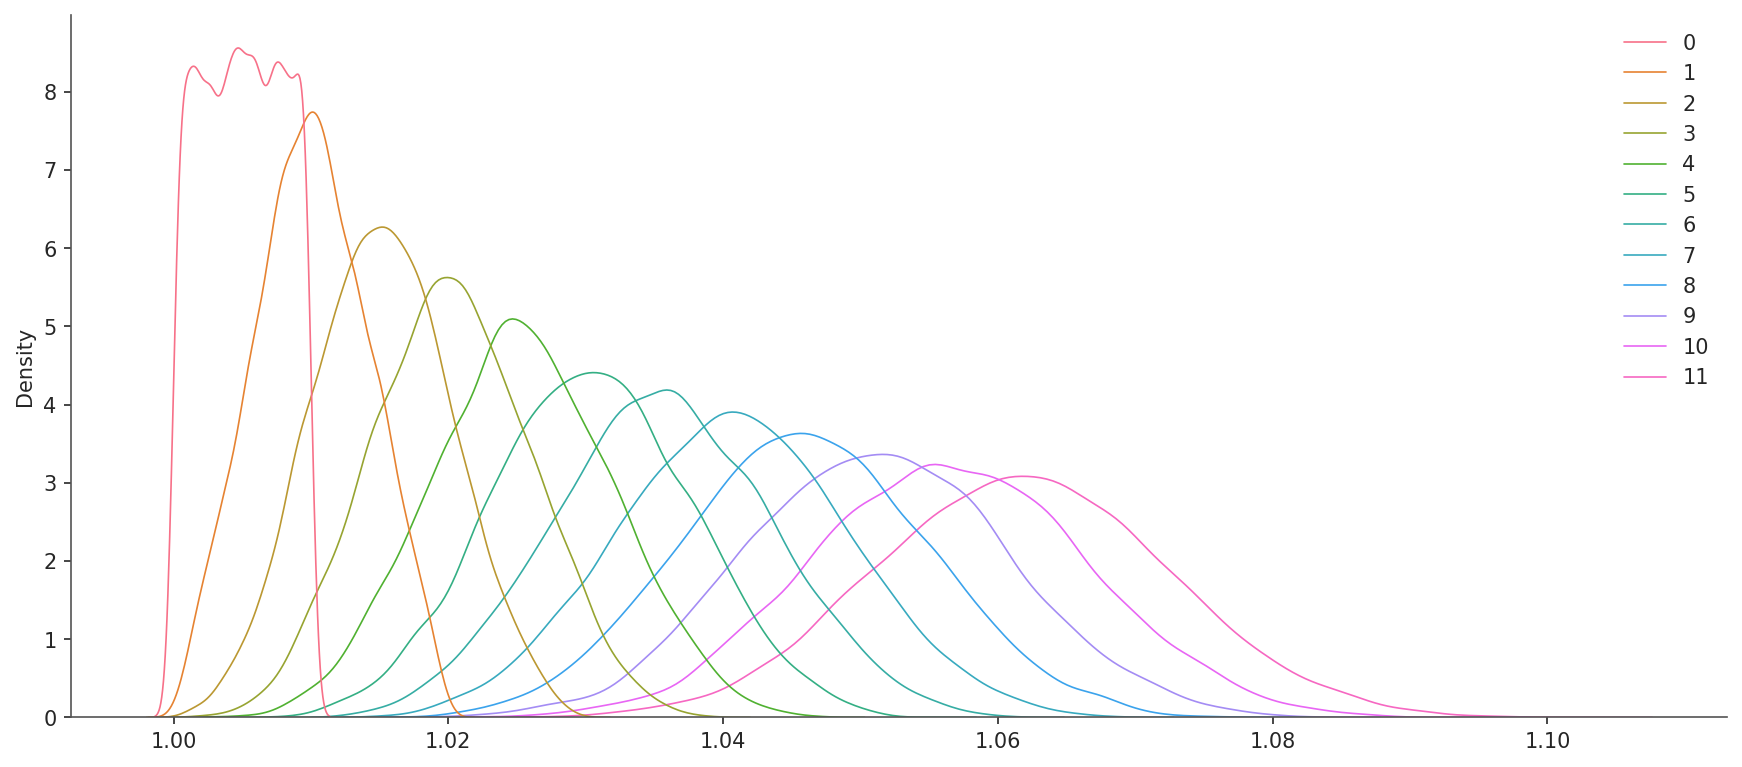

In [62]:
growth = runif((int(1e4), 12), 1, 1.01).cumprod(1)
sns.kdeplot(growth);

The smaller the maximum multiplicative factor can be, the closer the curve is to the bell shape. But wait, large multiplicative factors do tend towards a log normal distribution.

### Code 4.5 (log normal growth)

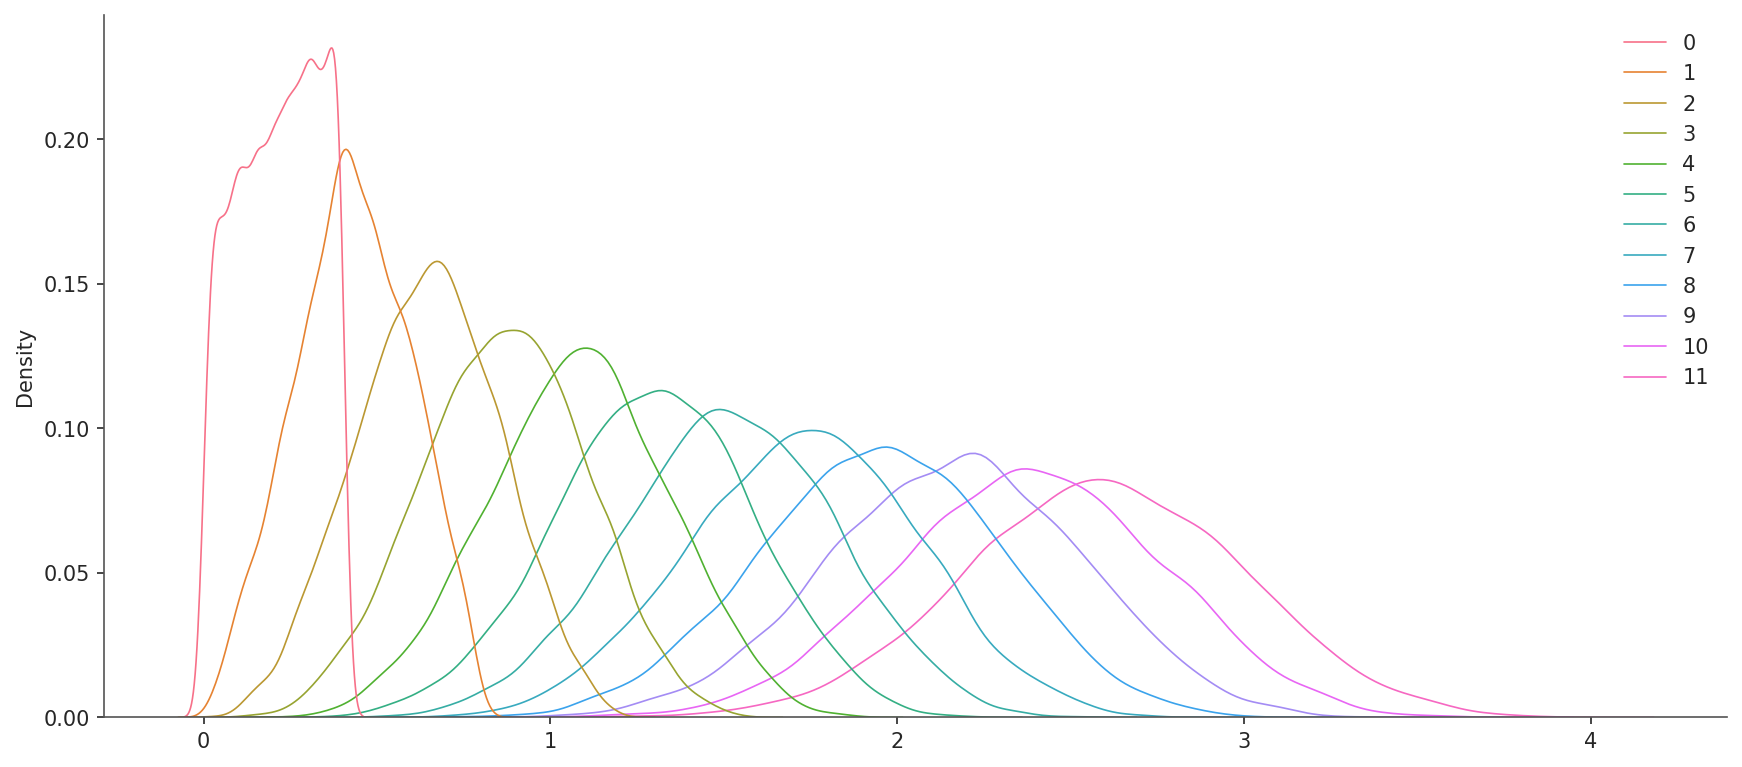

In [63]:
log_big = np.log(runif((int(1e4), 12), 1, 1.5)).cumsum(1)
sns.kdeplot(log_big);

(4.1.4) The justifications for using normal distributions:
1. _Ontological justification_. Whenever there are processes that add together fluctuations, the fluctuations themselves might become less important than their mean and spread. Doing this often prevents us from knowing more about the underlying fluctuations. In a word, Gaussians are just part of the nature.
2. _Epistemological justification_. Gaussian distributions are the most natural expression of our state of ignorance, besides knowing the mean and the variance of the distribution. We will look into this more in later chapters when we talk about information theory and maximun entropy (maxent).

But many natural and unnatural processes have much heavier tails. For example, stock prices can look Gaussian in the short term, but extreme shocks during a long time window make the Gaussian model look foolish. 

An alternative parametrization of Gaussians uses $\tau = 1/\sigma^2$ instead of $\sigma$, called the "precision". 

---
## Section 4.2. A language for describing models

McElreath tends to refer to data as observed variables, and parameters as unobserved variables. So he makes that point here. Another point is that we should unify our language of defining our statistical models to a form that's similar to how stan or PyMC defines them with code. That way, you do not need to memorize the meaning of crazy terms like _heteroscedasticity_, you can just read the assumptions from your model definition.

### Code 4.6 (grid approximation)
Model:
$$W \sim \text{Binomial}(N, p)$$
$$p \sim \text{Uniform}(0, 1)$$

In [10]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = dbinom(w, n, p_grid)*dunif(p_grid, 0, 1)
posterior /= posterior.sum()

---
## Section 4.3. Gaussian model of height

We want our Bayesian model to rank all combinations of means and variances by the posterior plausibility.

### Code 4.7 (read Howell1 data)

In [11]:
from utils.data import data
d = data("Howell1")

### Code 4.8 (cont'd)

In [12]:
d

height     weight   age  male
0    151.765  47.825606  63.0     1
1    139.700  36.485807  63.0     0
2    136.525  31.864838  65.0     0
3    156.845  53.041914  41.0     1
4    145.415  41.276872  51.0     0
..       ...        ...   ...   ...
539  145.415  31.127751  17.0     1
540  162.560  52.163080  31.0     1
541  156.210  54.062497  21.0     0
542   71.120   8.051258   0.0     1
543  158.750  52.531624  68.0     1

[544 rows x 4 columns]

### Code 4.9 (cont'd)

In [13]:
precis(d)

mean     sd   5.5%   94.5%
height  138.26  27.60  81.11  165.74
weight   35.61  14.72   9.36   54.50
age      29.34  20.75   1.00   66.13
male      0.47   0.50   0.00    1.00

We are just studying the height column for now.

### Code 4.10 (cont'd)

In [14]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

### Code 4.11 (cont'd)

Let's now just ignore the correlation between age and height that is often present in non-adults, by simplying filtering out the non-adults data points.

In [15]:
d2 = d[d.age >= 18]

Plot a density plot for the height and see if it looks like a bell curve. The answer is yes. This may be because height is a sum of many small growth factors. But gawking at the data to decide how to model them is usually not a good idea. 

**Rethinking: I.I.D.**. This assumption is hardly true in a physical sense. For the heights in the Howell data, it could be that some of these individuals are from the same families.

But the I.I.D. assumption doesn't need to seem awkward. It is an epistemological assumption, rather than an ontological one. It's only about how our models represent their uncertainty. Jaynes called this the [mind projection fallacy](https://en.wikipedia.org/wiki/Mind_projection_fallacy), when people confuse epistemological claims with ontological claims.

Let's build a model for the adult heights.
$$h_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu \sim \text{Normal}(178, 20)$$
$$\sigma \sim \text{Uniform}(0, 50)$$

Why 178 cm? McElreath is 178 cm tall. And 178 +- 40 encompasses a wide range of plausible human mean heights. Everybody knows something about human heights and thus can set a reasonable vague prior like this. But in many problems, using prior information is more subtle since parameters do not always have physical meaning. Whatever the prior, it's good to plot your priors for confirming what your assumptions are.

### Code 4.12 (plot prior of the mean heights)

See Figure 4.3 top left.

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
x = np.linspace(100, 250, 100)
ax[0, 0].plot(x, dnorm(x, 178, 20))
ax[0, 0].set(title="mu ~ dnorm(178, 20)", xlabel="mu")
plt.close()

### Code 4.13 (plot prior of the height variance)

See Figure 4.4 top right.

How should we pick the upper bound? A standard deviation of 50 cm would imply that 95% of individual heights lie within 100cm of the average height (small world numbers). That's a very large range.

In [53]:
x = np.linspace(-10, 60, 100)
ax[0, 1].plot(x, dunif(x, 0, 50))
ax[0, 1].set(title="sigma ~ dunif(0, 50)", xlabel="sigma");

### Code 4.14 (prior pred of first model)

It also helps to see what our priors imply about the simulated individual heights. (**prior predictive simulation**).

See Figure 4.3 bottom left.

In [54]:
n_samples = int(1e4)
sample_mu = rnorm(n_samples, 178, 20)
sample_sigma = runif(n_samples, 0, 50)
prior_h = rnorm(n_samples, sample_mu, sample_sigma)

plt.setp(ax, yticklabels=[])
sns.kdeplot(prior_h, bw_adjust=.4, ax=ax[1, 0])
ax[1, 0].set(title="h ~ dnorm(mu, sigma)", xlabel="height");

### Code 4.15 (prior pred, alt)

See Figure 4.3 bottom right.

Consider a much flatter prior $\mu \sim \text{Normal}(178, 100)$.  Note that there is a significant portion of humans with negative heights, also with heights more than 272 cm (one of the tallest people in history).

These crazy priors are not harmful here because we have 544 rows of data. But for cases where data are not sufficient, we have to use our scientific knowledge to construct sensible priors, then we can use Bayes to proceed.

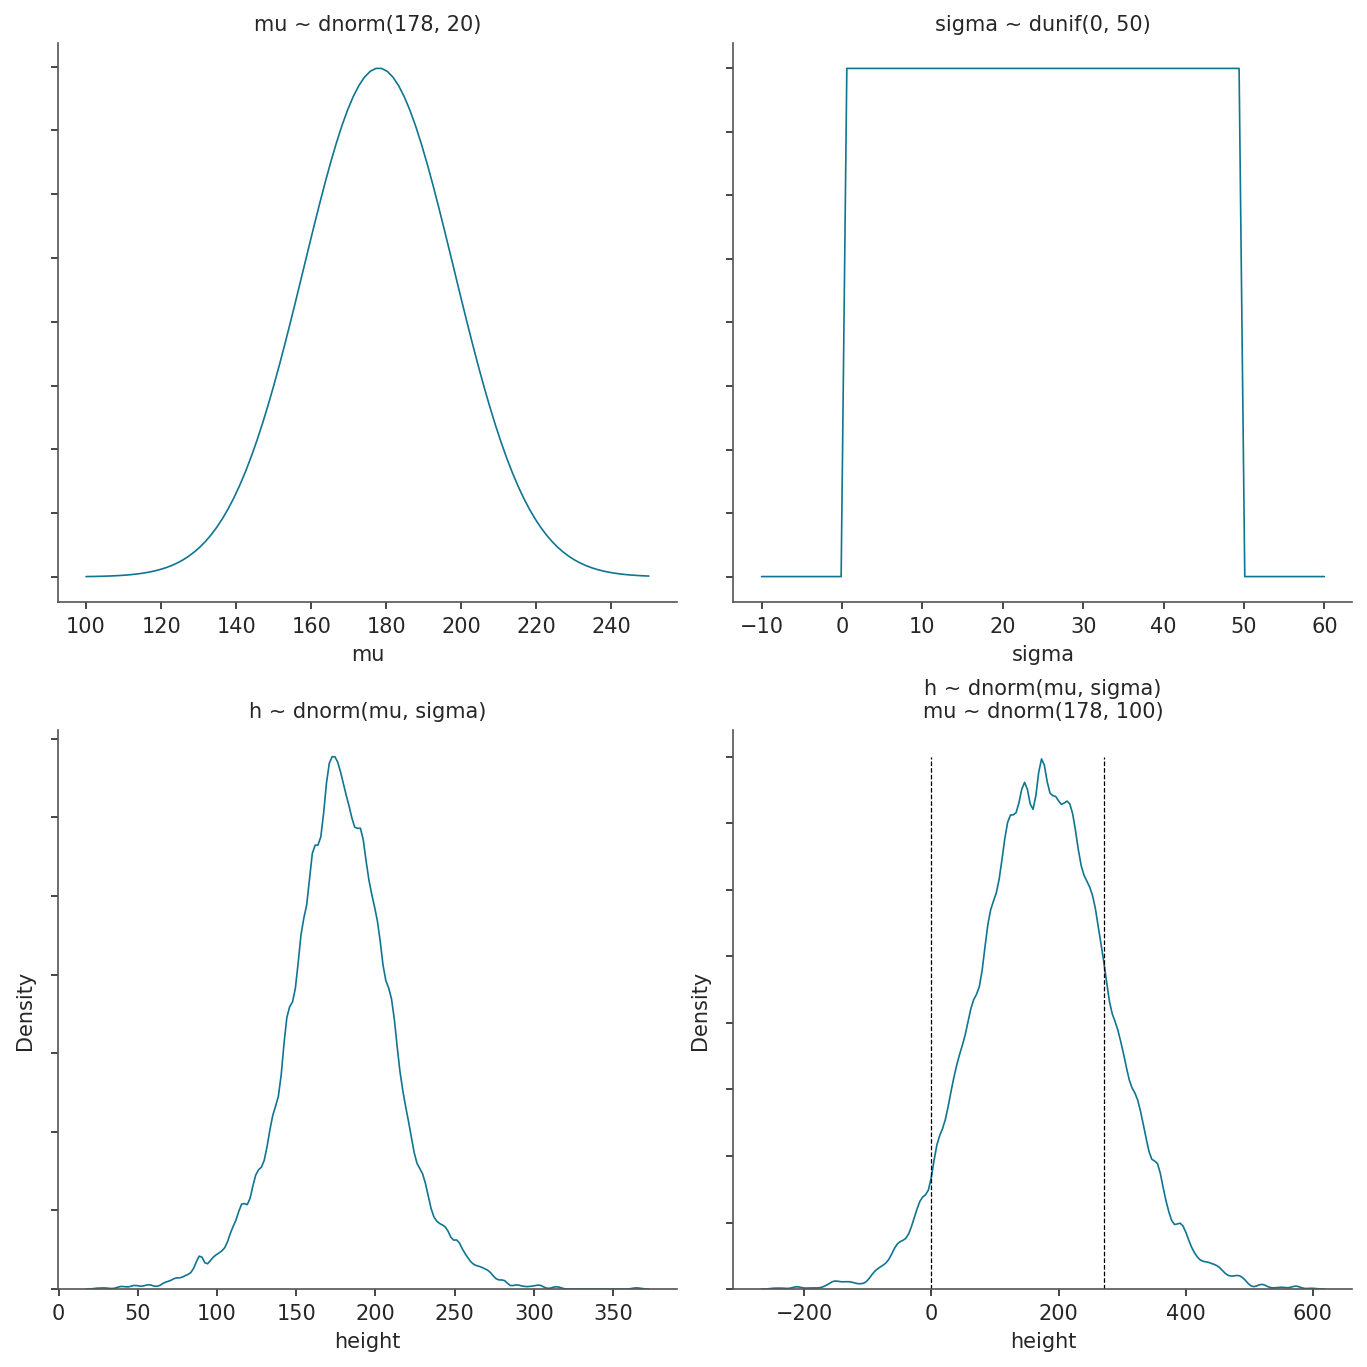

In [55]:
sample_mu = rnorm(n_samples, 178, 100)
prior_h = rnorm(n_samples, sample_mu, sample_sigma)
sns.kdeplot(prior_h, bw_adjust=.4, ax=ax[1, 1])
ax[1, 1].vlines(x=[0, 272], ymin=0, ymax=0.004, linestyles=["dashed"], colors=["k"], linewidth=0.6)
ax[1, 1].set(title="h ~ dnorm(mu, sigma)\nmu ~ dnorm(178, 100)", xlabel="height")
fig

Figure 4.3. Top row: prior distributions for $\mu$ and $\sigma$. Bottom row: prior predictive simulations for height, left with the $\mu$ prior in our model, right with a flatter $\mu$ prior.

### Code 4.16 (grid approx, first model)

Since this is our first model, let's use grid approximation to calculate the posterior.


In [64]:
mus = np.linspace(150, 160, 100)
sigmas = np.linspace(7, 9, 100)
post_LL = dnorm(d2.height, mus.reshape(1, -1, 1), sigmas.reshape(-1, 1, 1), log=True).sum(-1)
post_prod = post_LL + dnorm(mus.reshape(1, -1), 178, 20, True) \
                    + dunif(sigmas.reshape(-1, 1), 0, 50, True)
post_prob = np.exp(post_prod - post_prod.max())

### Code 4.17 (grid posterior contour)

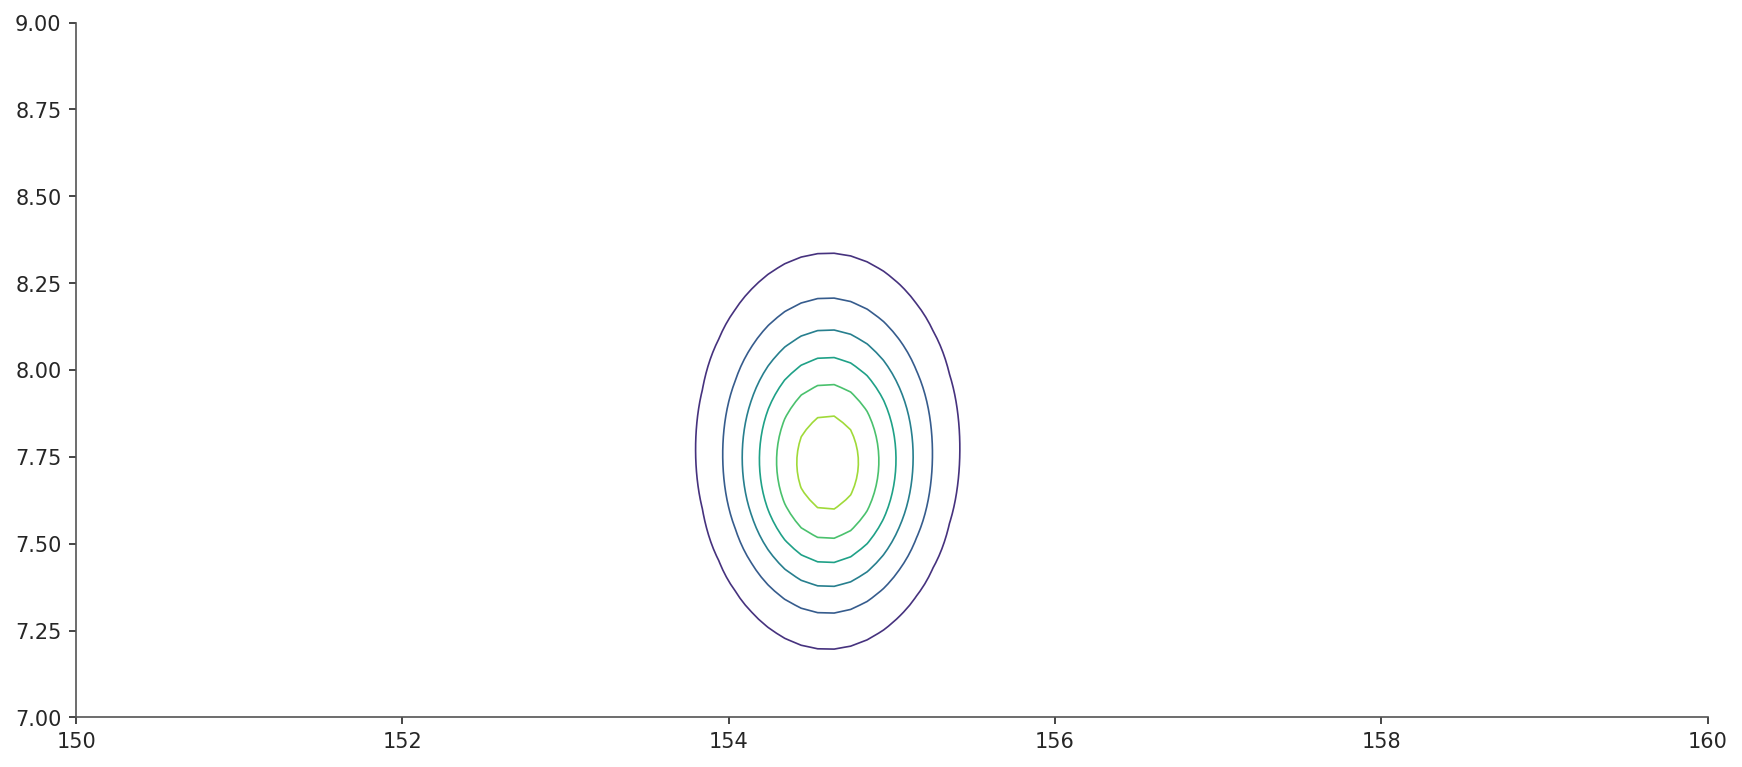

In [65]:
plt.contour(mus, sigmas, post_prob);

### Code 4.18 (2d grid posterior heatmap)

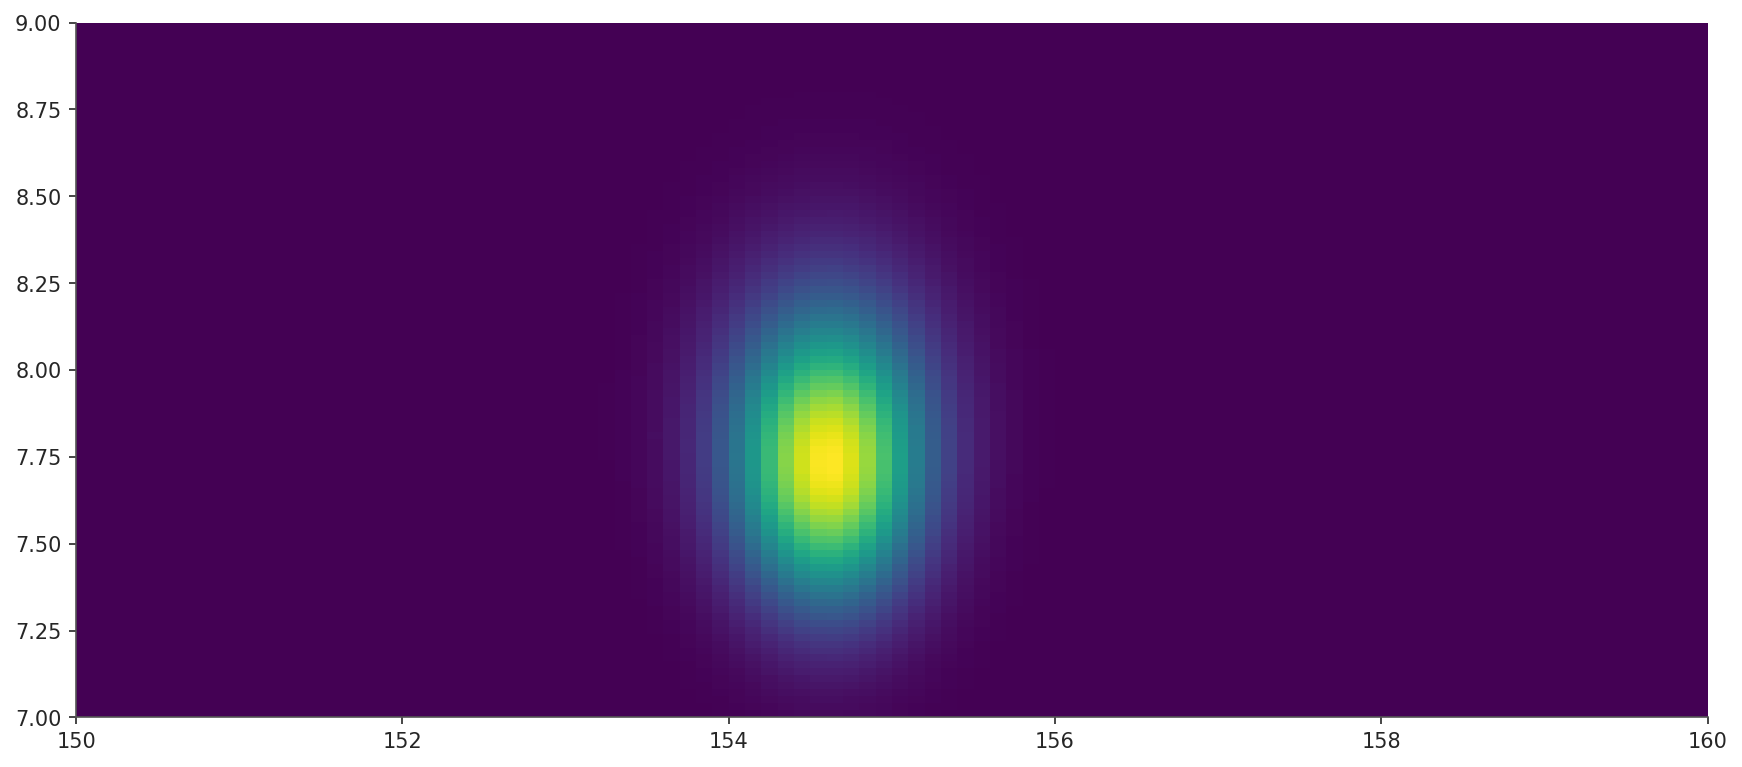

In [66]:
_, ax = plt.subplots()
ax.imshow(post_prob, origin="lower", aspect="auto", 
          extent=[mus.min(), mus.max(), sigmas.min(), sigmas.max()])
ax.grid(False);

### Code 4.19 (posterior sample from 2d grid)

In [67]:
mu_copies, sigma_copies = np.meshgrid(mus, sigmas)
long_mus, long_sigmas, long_post_prob = mu_copies.flatten(), sigma_copies.flatten(), post_prob.flatten()

sample_rows = choice(
    np.arange(len(long_mus)), size=10000, replace=True, p=long_post_prob/long_post_prob.sum()
)

sample_mus = long_mus[sample_rows]
sample_sigmas = long_sigmas[sample_rows]

### Code 4.20 (plot sampled 2d params)

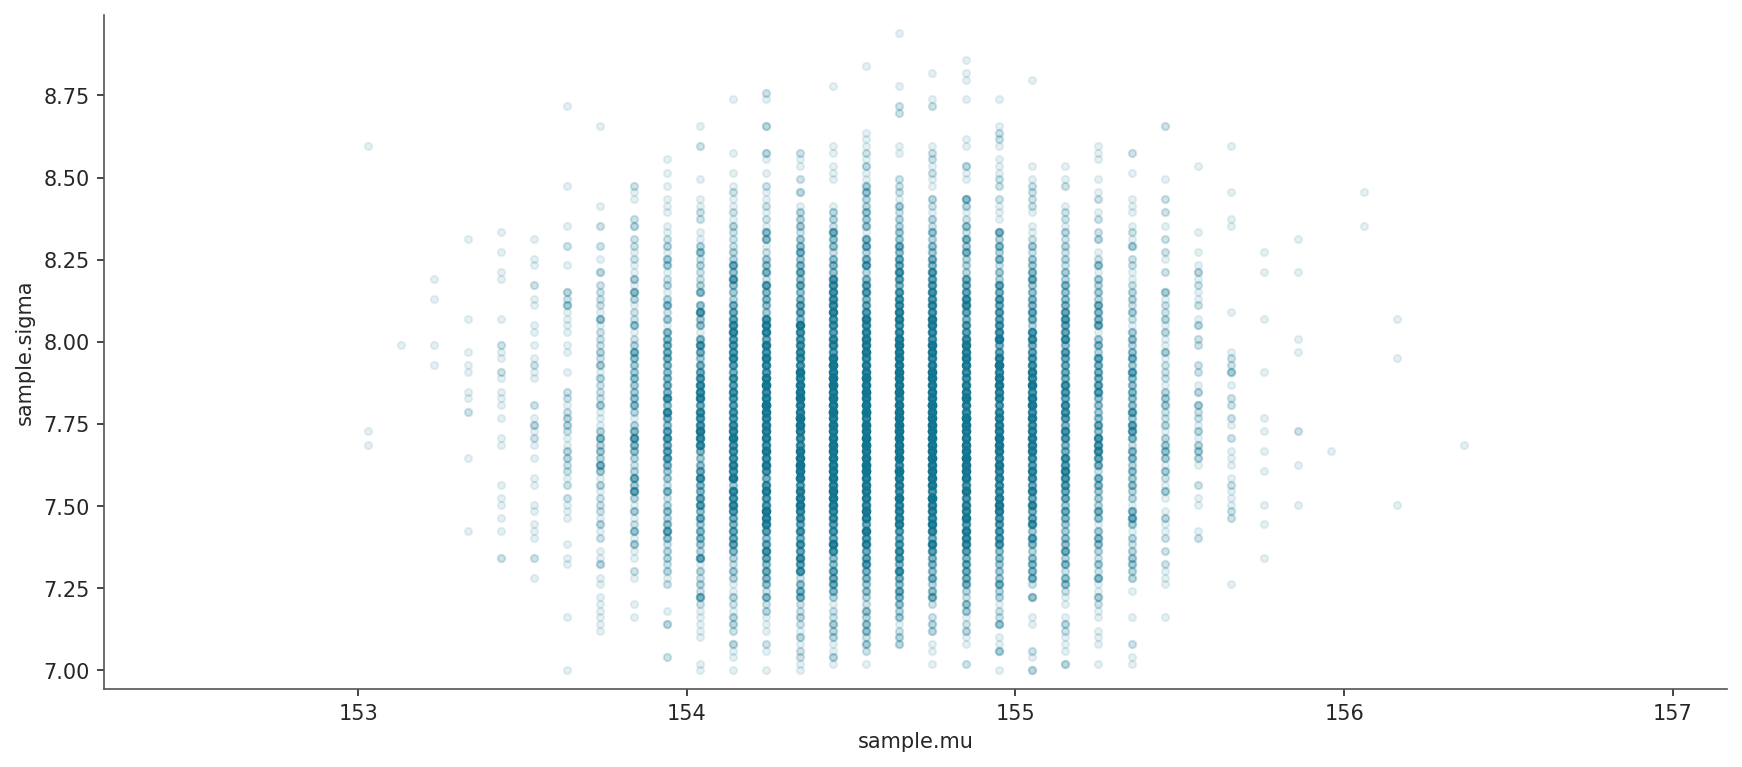

In [71]:
ax = plt.subplot(aspect="auto")
ax.axis("equal")
ax.plot(sample_mus, sample_sigmas, ".", alpha=0.1)
ax.set(xlabel="sample.mu", ylabel="sample.sigma");

Figure 4.4. Samples from the posterior distribution for the heights data.

### Code 4.21 (marginal plots)

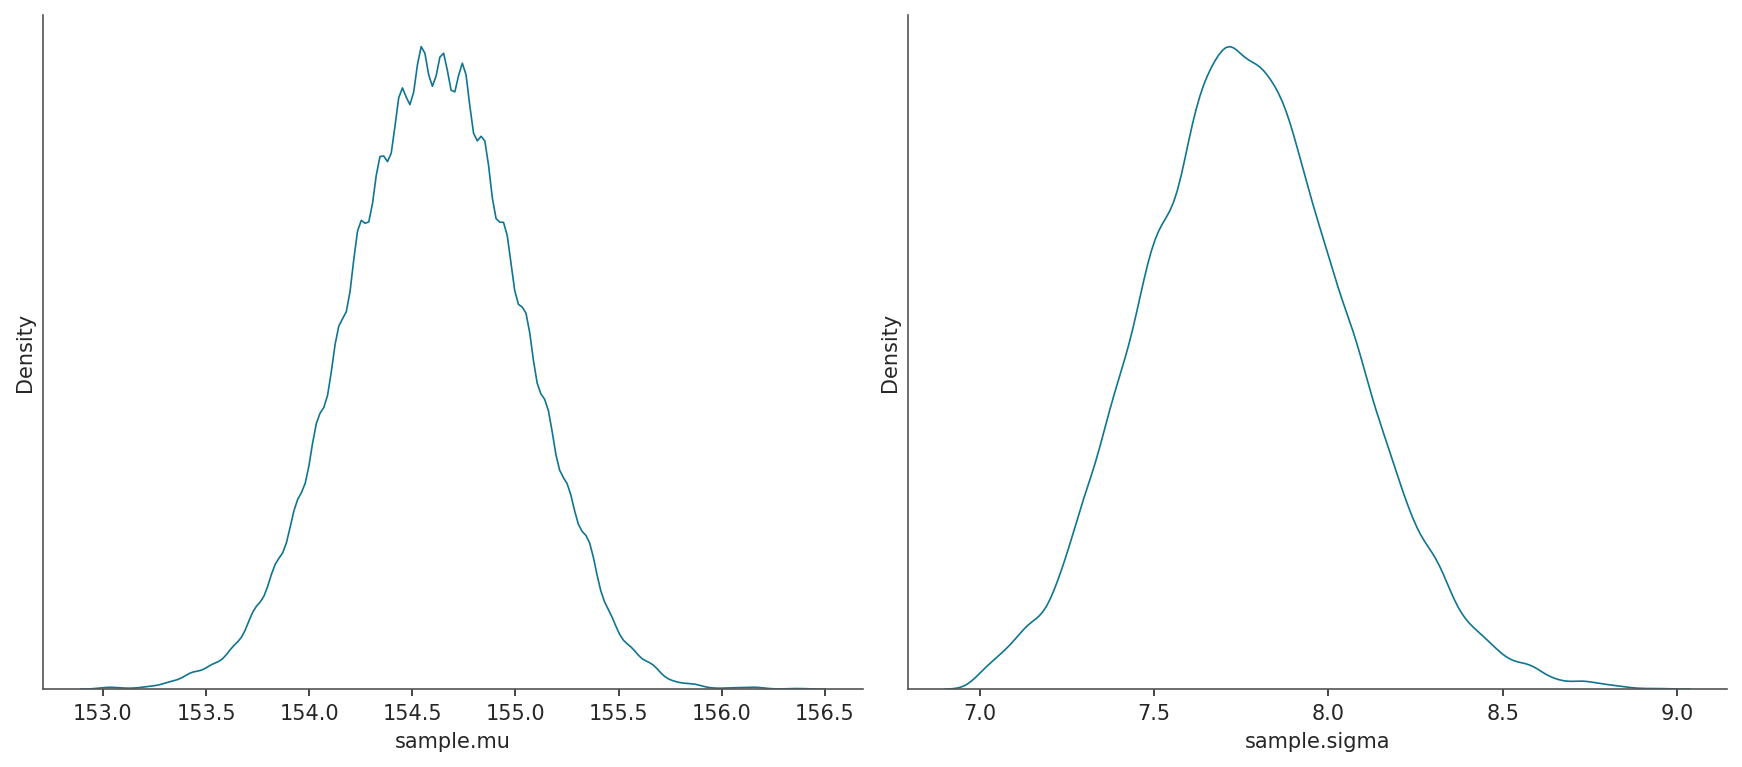

In [72]:
_, ax = plt.subplots(1, 2)
sns.kdeplot(sample_mus, bw_adjust=.7, ax=ax[0])
ax[0].set(xlabel="sample.mu")
sns.kdeplot(sample_sigmas, bw_adjust=.7)
ax[1].set(xlabel="sample.sigma")
plt.setp(ax, yticks=[]);

### Code 4.22 (plausibility intervals)

In [73]:
az.hdi(sample_mus), az.hdi(sample_sigmas)

(array([153.83838384, 155.15151515]), array([7.26262626, 8.19191919]))

We are about to forget the grid approximation and get to quadratic approximation. Often if you do quadratic approximation for your normal posterior, the $\sigma$ tends to have a long right tail. An intuitive explanation is, the bigger the variance, the bigger the uncertainty.

It is deemed worth repeating the analysis of the height data above, but now with only a fraction of the data, to demonstrate the point discussed above.

### Code 4.23 (subset of Howell1)

In [74]:
d3 = choice(d2.height, 20)

### Code 4.24 (grid approx on subset)

In [75]:
mus = np.linspace(150, 170, 200)
sigmas = np.linspace(4, 20, 200)
post_LL = dnorm(d3, mus.reshape(1, -1, 1), sigmas.reshape(-1, 1, 1), log=True).sum(-1)
post_prod = post_LL + dnorm(mus.reshape(1, -1), 178, 20, True) \
                    + dunif(sigmas.reshape(-1, 1), 0, 50, True)
post_prob = np.exp(post_prod - post_prod.max())

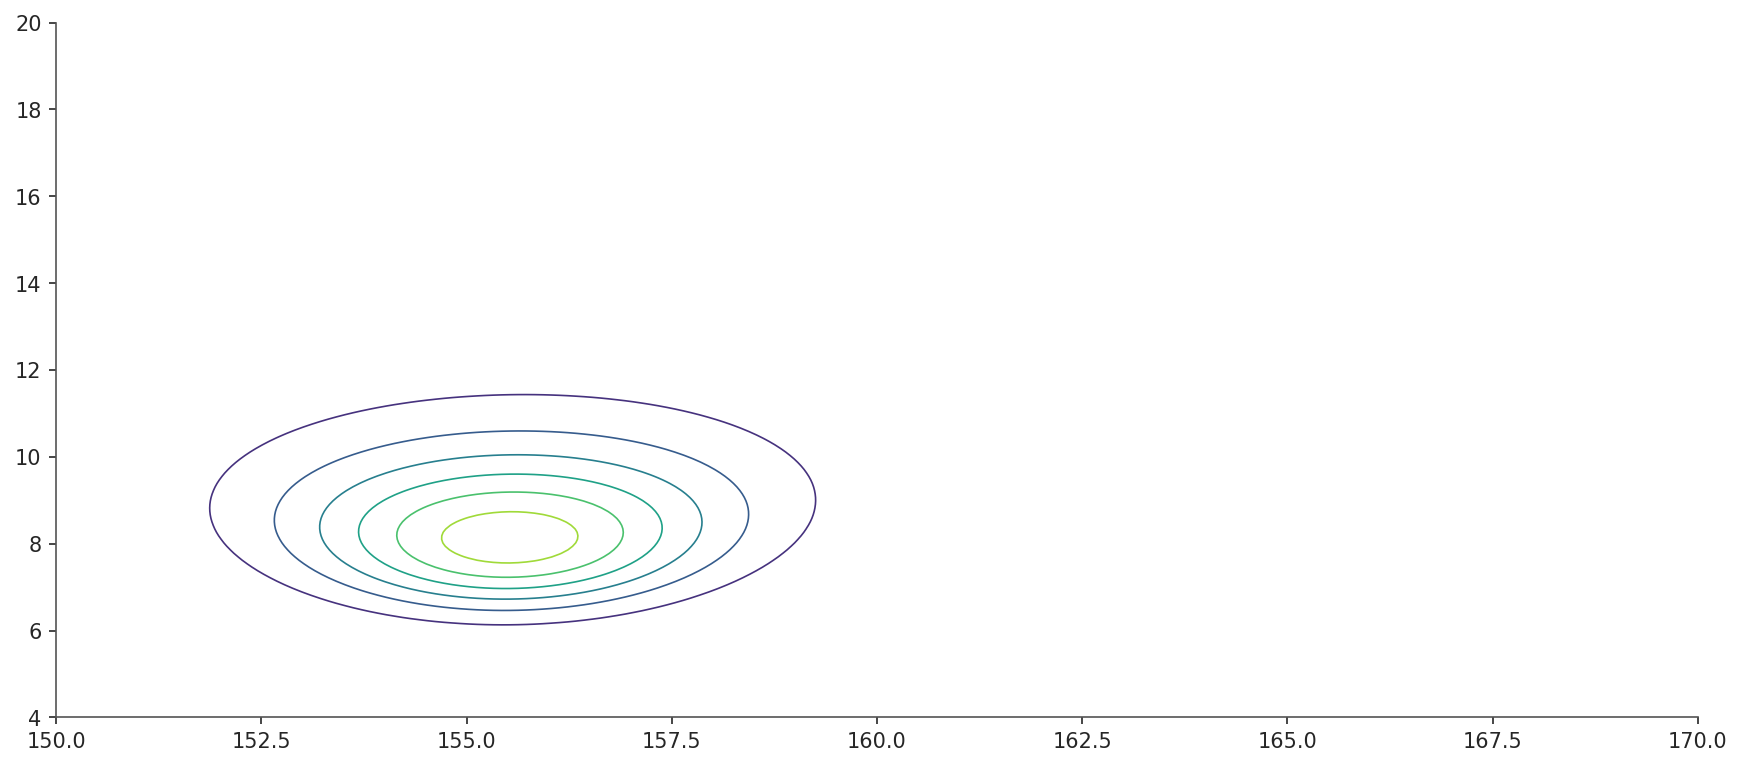

In [76]:
plt.contour(mus, sigmas, post_prob);

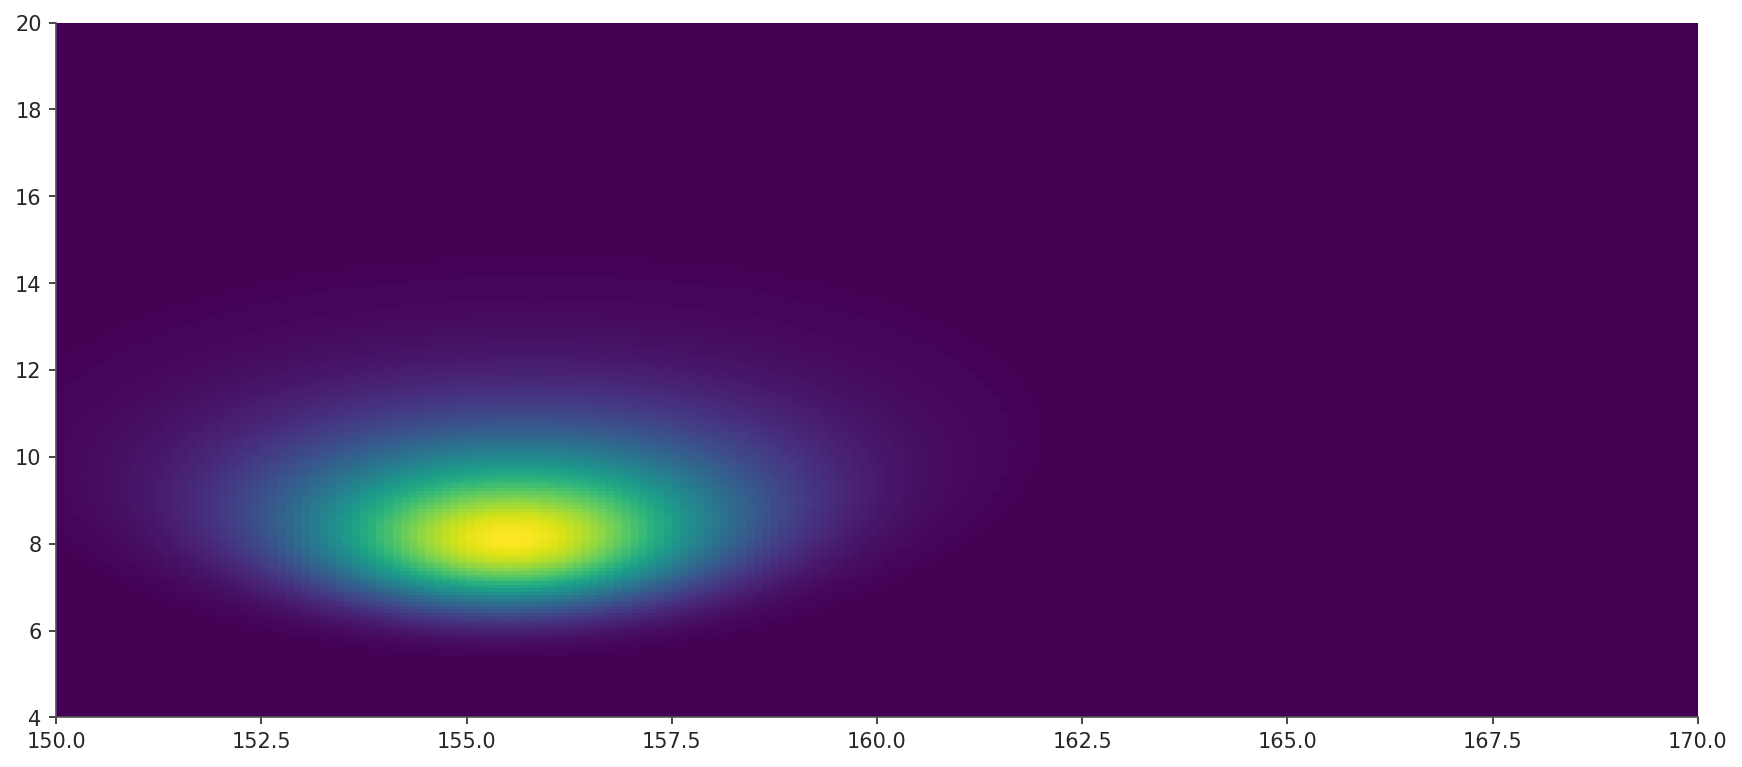

In [77]:
_, ax = plt.subplots()
ax.imshow(post_prob, origin="lower", aspect="auto", 
          extent=[mus.min(), mus.max(), sigmas.min(), sigmas.max()])
ax.grid(False);

In [78]:
mu_copies, sigma_copies = np.meshgrid(mus, sigmas)
long_mus, long_sigmas, long_post_prob = mu_copies.flatten(), sigma_copies.flatten(), post_prob.flatten()

sample_rows = choice(
    np.arange(len(long_mus)), size=10000, replace=True, p=long_post_prob/long_post_prob.sum()
)

sample_mus = long_mus[sample_rows]
sample_sigmas = long_sigmas[sample_rows]

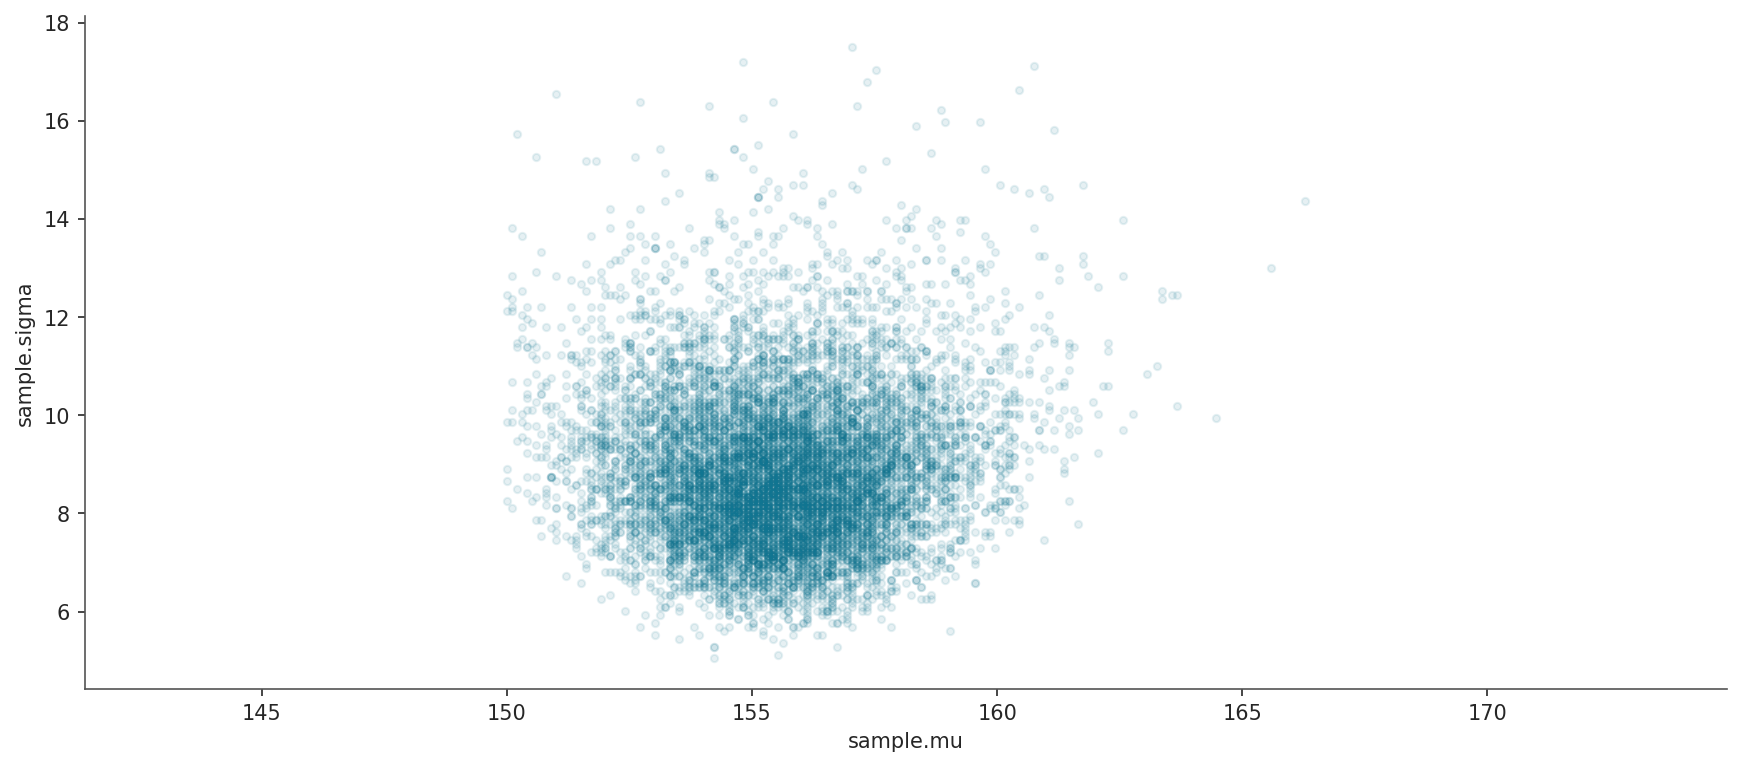

In [81]:
ax = plt.subplot(aspect="auto")
ax.axis("equal")
ax.plot(sample_mus, sample_sigmas, ".", alpha=0.1)
ax.set(xlabel="sample.mu", ylabel="sample.sigma");

From the plots, we can see that sigma's posterior has a long right tail. Also see the posterior plot below.

### Code 4.25 (sigma posterior plot)

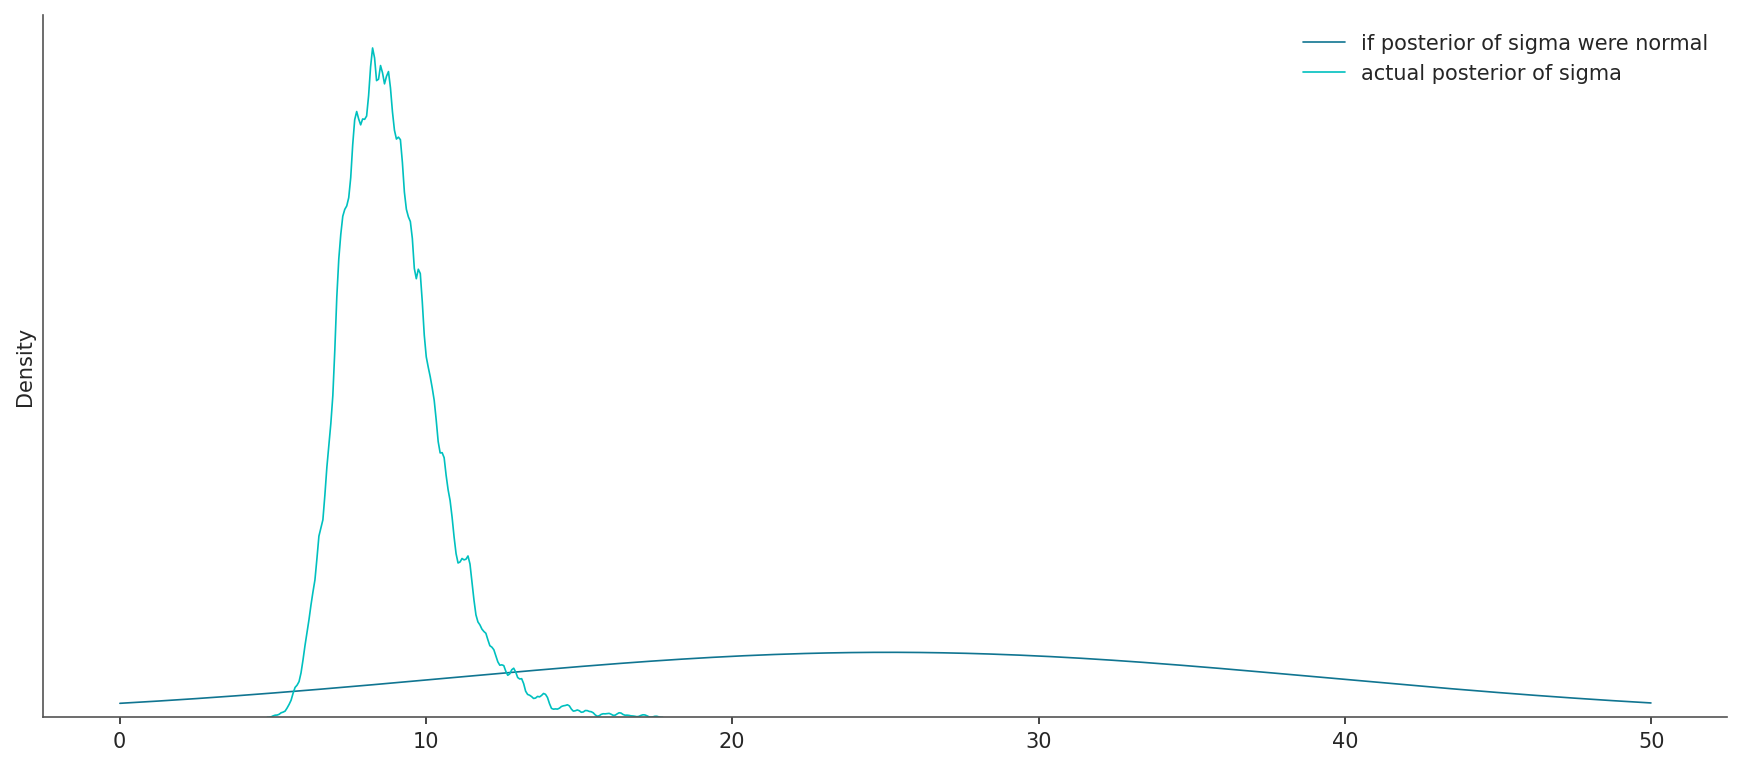

In [82]:
sigs = np.linspace(sample_sigma.min(), sample_sigma.max(), 200)
plt.plot(sigs, dnorm(sigs, sample_sigma.mean(), sample_sigma.std()), label="if posterior of sigma were normal")
sns.kdeplot(sample_sigmas, bw_adjust=.3, label="actual posterior of sigma")
plt.legend()
plt.yticks([]);

4.3.5 Quadratic approximation. This type of optimizer finds the peak/MAP/mode of the posterior, and also estimates the quadratic curvature at the MAP to produce an approximated posterior. **This is very similar to what many non-Bayesian procedures do, just without the priors.**

Consider a unimodal posterior density of $x$, $f(x)$, whose maximum is $x_0$. We can just approximate this density by doing a 2nd-order Taylor approximation around the posterior mode (given that we located the mode) on the log scale. The first order term becomes zero because the first derivative is evaluated at the mode, then we are left with a quadratic term to be then exponentiated (sounds quite familiar eh?), and a constant factor.

Laplace/normal/quadratic approximation replaces the problem of integration with the problem of maximization. Maximizing something often comes faster with a lot of off-the-shelf optimizers.

### Code 4.26 (reload Howell1 data)

In [83]:
d = data("Howell1")
d2 = d[d.age >= 18]

### Code 4.27 - 4.28 (quadratic approx with `autograd` and `scipy`)

In [84]:
mu_mu, mu_sigma = 178, 20
sigma_l, sigma_u = 0, 50

def height_model_obj(params, data):
    mu, sigma = params
    out = dnorm_(data, mu, sigma).sum()
    out += dnorm_(mu, mu_mu, mu_sigma)
    out += dunif_(sigma, sigma_l, sigma_u)
    return -out

m4_1 = pyquap()
m4_1.define_objective(height_model_obj)
m4_1_pars0 = {"mu": f"rnorm(1, {mu_mu}, {mu_sigma})", 
              "sigma": f"runif(1, {sigma_l}, {sigma_u})"
             }
m4_1.initialize(m4_1_pars0)
m4_1.fit(data=d2.height.values)

Optimization terminated successfully.


### Code 4.29 (sample posterior params)

In [85]:
m4_1.sample(4000).head()

mu     sigma
0  154.580169  7.244082
1  154.959548  7.523076
2  154.749418  7.869018
3  154.974578  7.944613
4  155.115246  7.792605

If comparing the above summary table with that from a grid approximation (summarize grid approximated samples from previous code this section), you will find they are quite similar. This is expected if the true posterior is approximately Gaussian.

**Overthinking: initial parameter values for finding the posterior mode.** In Code 4.27-4.28, the initial parameter values fed to the optimizer are sampled from the prior. But it's also possible to specify initial values with information from the data.

### Code 4.30 (quadratic approx, informed initial values)

In [13]:
m4_1_pars0 = {"mu": d2.height.mean(), 
              "sigma": d2.height.std()
             }
m4_1.initialize(m4_1_pars0)
m4_1.fit(data=d2.height.values)

Optimization terminated successfully.


### Code 4.31 (concentrated mu prior)

In [14]:
mu_mu, mu_sigma = 178, .1
sigma_l, sigma_u = 0, 50

m4_2 = pyquap()
m4_2.define_objective(height_model_obj)
m4_2_pars0 = {"mu": f"rnorm(1, {mu_mu}, {mu_sigma})",
              "sigma": f"runif(1, {sigma_l}, {sigma_u})"
             }
m4_2.initialize(m4_2_pars0)
m4_2.fit(data=d2.height.values)
m4_2.precis()

Optimization terminated successfully.


mean    sd    5.5%   94.5%
mu     177.86  0.10  177.71  178.02
sigma   24.52  0.93   23.02   26.01

Notice that the posterior $\mu$ mode has hardly moved off the prior. But also notice that the $\sigma$ posterior mean has changed a lot from `m4_1`, even if we didn't modify the prior of $\sigma$. 

Once the golem is certain that `mu` is near 178 regardless of what the data says, then the golem needs to change where `sigma` lies to condition on that asserted belief, to get a good fit on the data. 

### Code 4.32 (get covariance matrix)

In [15]:
m4_1.model.cov

array([[1.69784910e-01, 2.68394363e-05],
       [2.68394363e-05, 8.52032891e-02]])

### Code 4.33 (covar and corr matrices)

In [16]:
print(np.diag(m4_1.model.cov).round(3))
print(cov2cor(m4_1.model.cov).round(3))

[0.17  0.085]
[[1. 0.]
 [0. 1.]]


The near zero correlation between posterior $\mu$ and $\sigma$ means that learning one of the two does not tell anything about the second.

### Code 4.34 (sample posteriors)

In [50]:
post = m4_1.sample(int(1e4))
post[:6]

mu     sigma
0  155.093480  8.225591
1  154.330877  7.414394
2  154.803453  8.124536
3  153.528594  8.045971
4  154.786748  7.790466
5  154.765555  7.925191

### Code 4.35 (summarize sampled posteriors)

In [18]:
m4_1.precis()

mean    sd    5.5%   94.5%
mu     154.61  0.42  153.96  155.29
sigma    7.74  0.29    7.29    8.19

Density plots of the posterior samples, generally similar to those from grid approximation (Code 4.21).

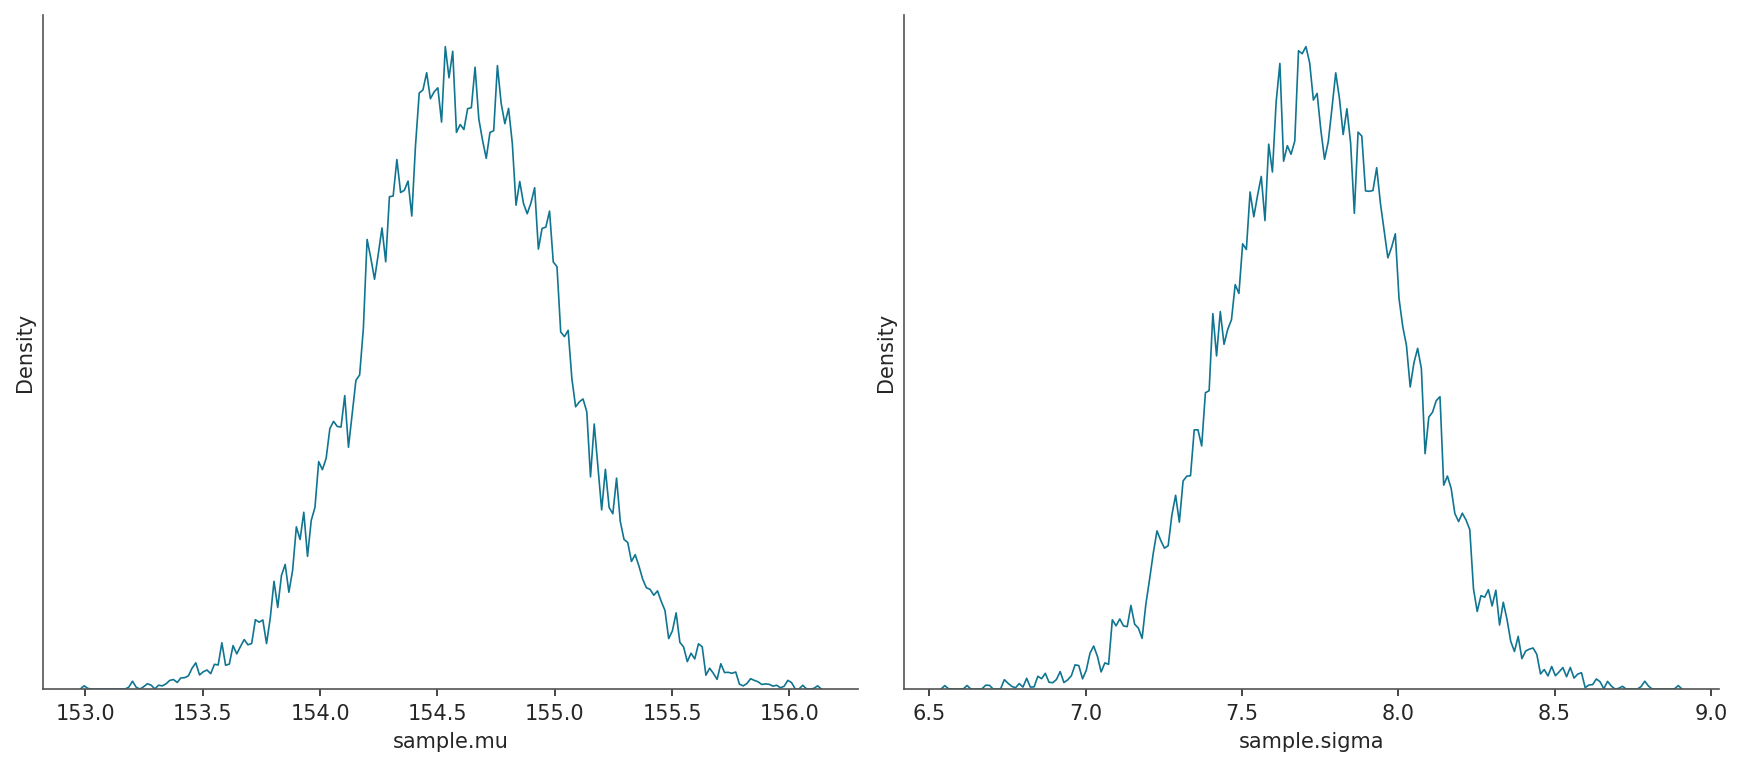

In [51]:
_, ax = plt.subplots(1, 2)
sns.kdeplot(post.mu, bw_adjust=.1, ax=ax[0])
ax[0].set(xlabel="sample.mu")
sns.kdeplot(post.sigma, bw_adjust=.1)
ax[1].set(xlabel="sample.sigma")
plt.setp(ax, yticks=[]);

**Overthinking: Under the hood with multivariate sampling.** This is actually quite straightforward. I just called `scipy.stats.multivariate_normal.rvs` with learned parameters' MAPs and covariances. Check the source in `../utils/algos.py`.

### Code 4.36 (sampling mvnorm under the hood)

In [20]:
from scipy.stats import multivariate_normal as mvnorm
post = mvnorm.rvs(size=int(1e4), mean=m4_1.model.mean, cov=m4_1.model.cov)

---
## Section 4.4 Linear prediction

### Code 4.37 (reg plot)



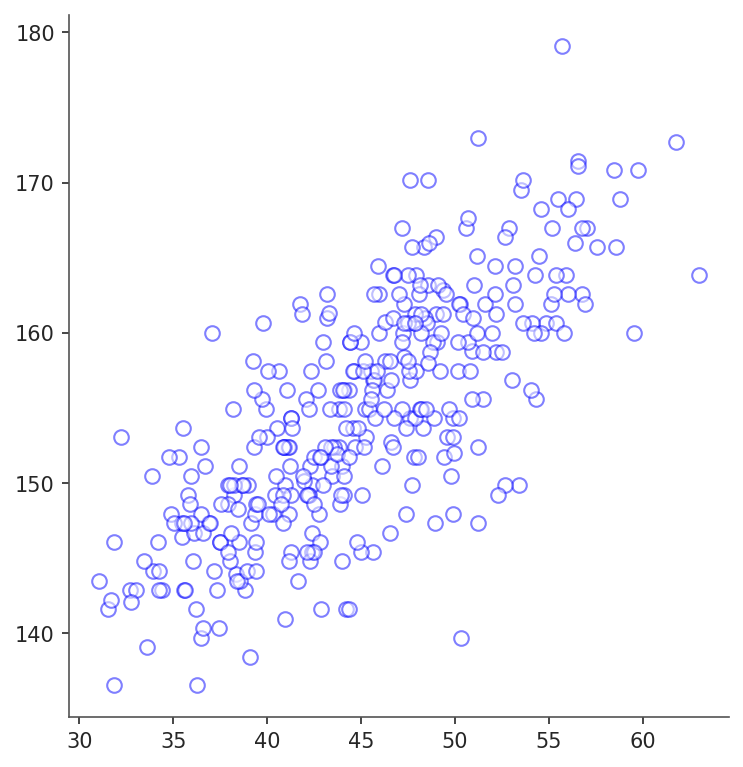

In [48]:
ax = plt.subplot(aspect=0.8)
scatter(d2.weight, d2.height, ax);

### Code 4.38 (simulate priors)

In [22]:
np.random.seed(2971)
N = 100
a = rnorm(N, 178, 20)
b = rnorm(N, 0, 10)

### Code 4.39 (plot priors)

See Figure 4.5.

In [23]:
fig, ax = plt.subplots(1, 2)

ax[0].set(title="b ~ dnorm(0, 10)", 
          xlim=[d2.weight.min(), d2.weight.max()])
ax[0].hlines(y=[0, 272], xmin=d2.weight.min(), xmax=d2.weight.max(), 
             color="k", linestyles="dashed")
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), 100)
for i in range(N):
    mu = a[i] + b[i]*(x - xbar)
    sns.lineplot(x=x, y=mu, alpha=0.2, color="k", ax=ax[0])
plt.close()

### Code 4.40 (`rlnorm` sampling)

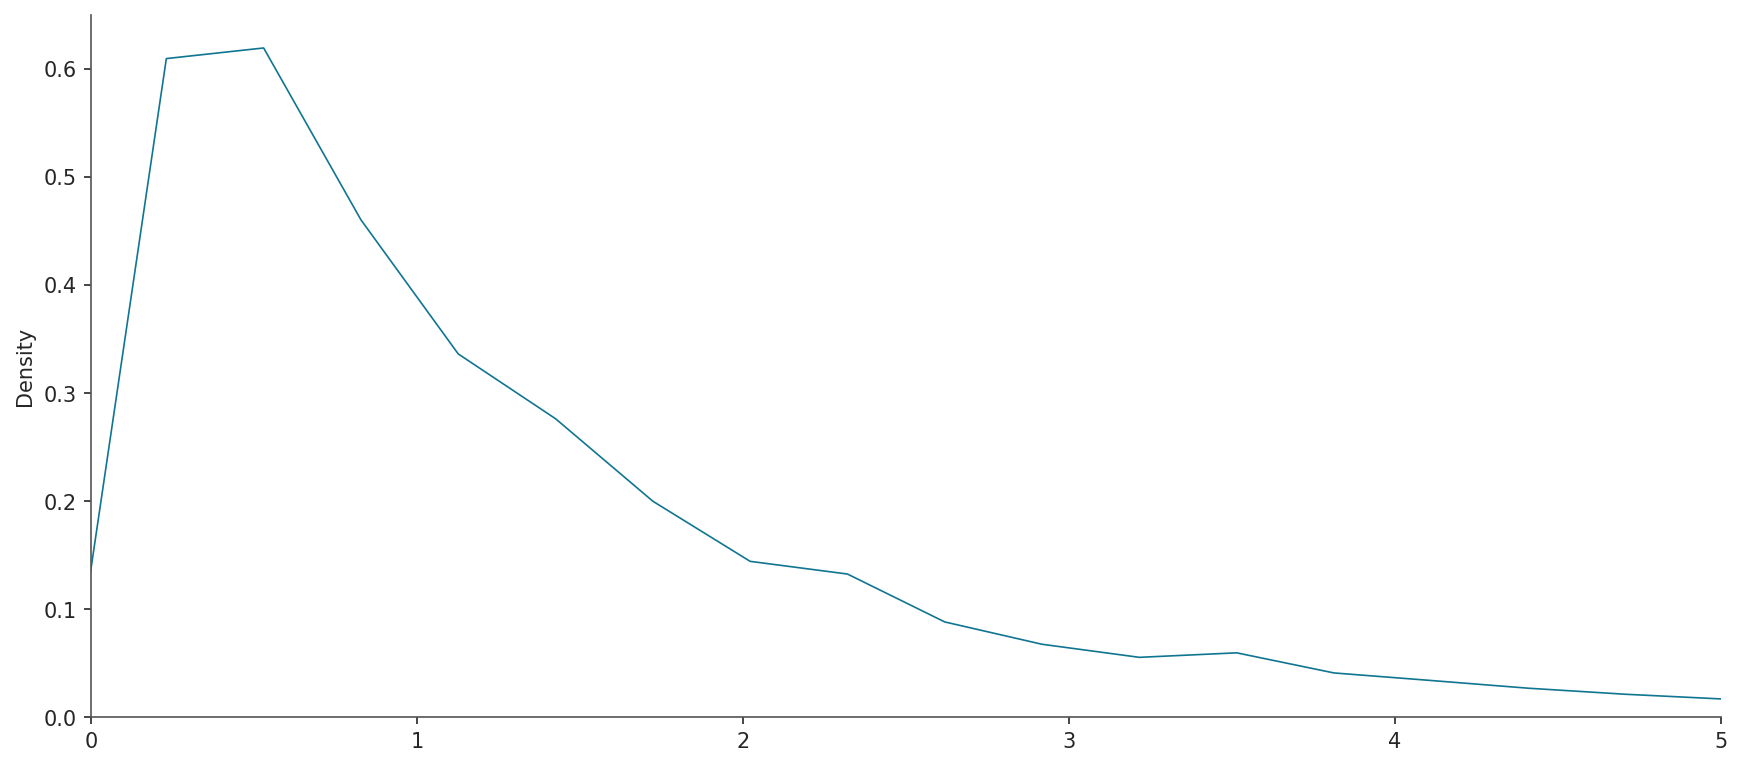

In [24]:
_, ax_ = plt.subplots()
b = rlnorm(int(1e4), 0, 1)
sns.kdeplot(b, bw_adjust=.1, ax=ax_)
ax_.set(xlim=[0, 5]);

### Code 4.41 (simulate priors, with lognormal slope)

In [25]:
np.random.seed(2971)
N = 100
a = rnorm(N, 178, 20)
b = rlnorm(N, 0, 1)

#### plot priors with lognormal slope

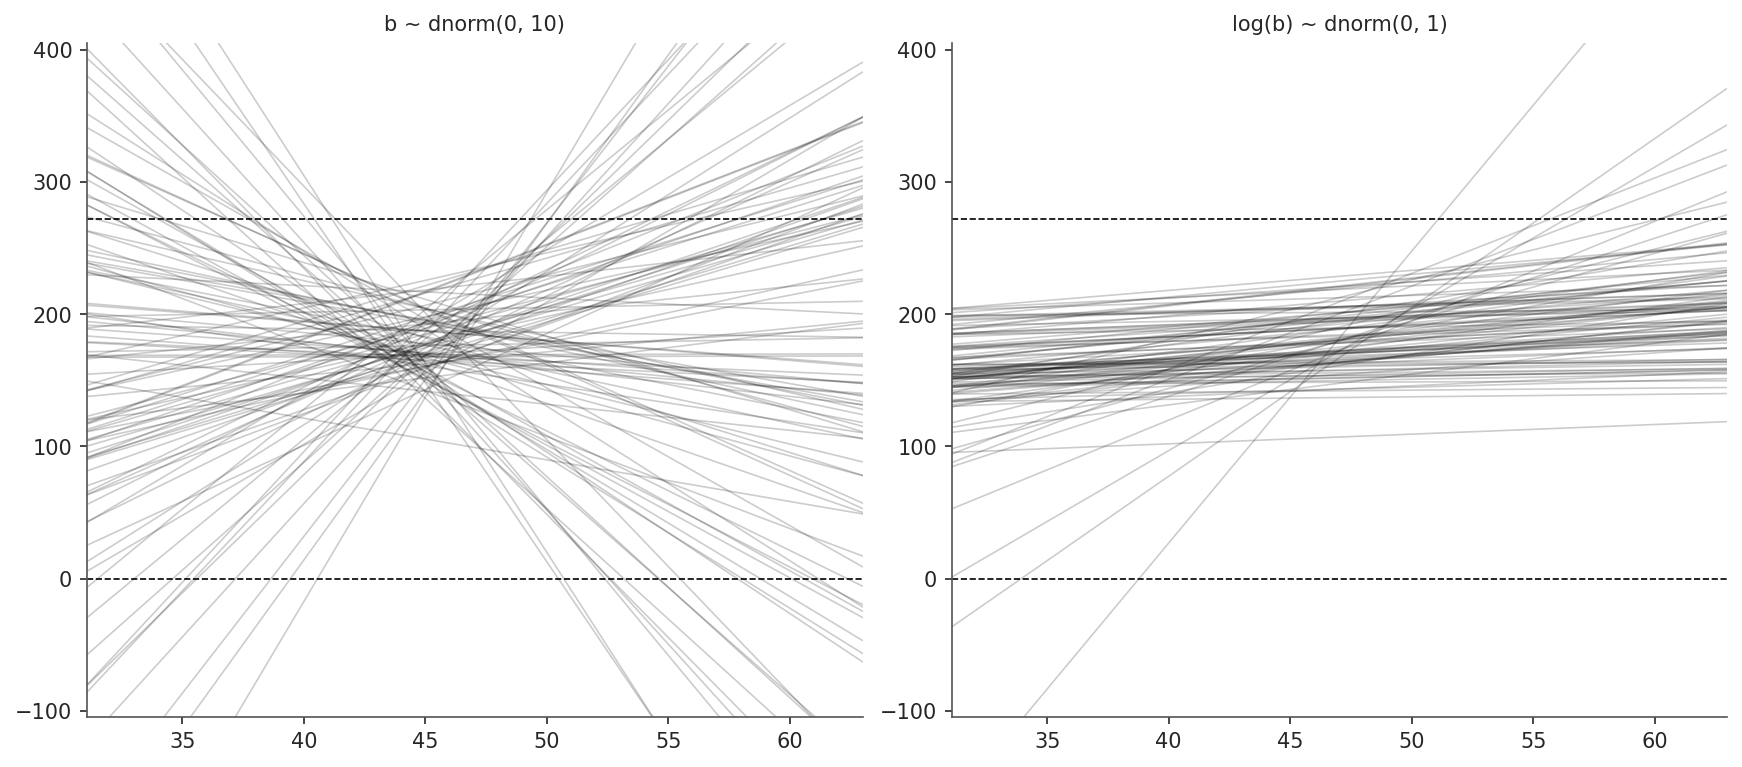

In [26]:
ax[1].set(title="log(b) ~ dnorm(0, 1)", 
          xlim=[d2.weight.min(), d2.weight.max()])
ax[1].hlines(y=[0, 272], xmin=d2.weight.min(), xmax=d2.weight.max(), 
             color="k", linestyles="dashed")
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), 100)
for i in range(N):
    mu = a[i] + b[i]*(x - xbar)
    sns.lineplot(x=x, y=mu, alpha=0.2, color="k", ax=ax[1])
plt.setp(ax, ylim=[-105, 405])
fig

Figure 4.5. Prior predictive simulation for the height and weight model. In fact, this dataset gives us enough data to make these priors not important at all after fitting the model. But thinking about priors can get us to better places if the amount of data is not sufficient, or if we want to go beyond geocentrism.

**Rethinking: What's the correct prior?**

Prior encodes states of information before seeing data. They allow us to explore the consequences of beginning with different information. If we confidently have some prior beliefs about the direction of variables' assocations, and/or the ranges the variables can take, we can strengthen our model priors with those beliefs.

**Rethinking: Prior predictive simulation and p-hacking.**

If we choose priors based on observed samples, that would be a form of p-hacking.

### Code 4.42 (`m4_3`, first height-weight model)

In [20]:
d = data("Howell1")
d2 = d[d.age >= 18]

def m4_3_obj(pars, data):
    a, b, sigma = pars
    wbar = data.w.mean()
    mu = a + b*(data.w - wbar)
    llhs = dnorm_(data.h, mu, sigma)
    llhs = llhs[np.isfinite(llhs)]
    out = llhs.sum()
    out += dnorm_(a, 178, 20)
    out += dlnorm_(b, 0, 1)
    out += dunif_(sigma, 0, 50)
    return -out
    

m4_3 = pyquap()
m4_3.define_objective(m4_3_obj)
m4_3_pars0 = {"a": "rnorm(1, 178, 20)",
              "b": "rlnorm(1, 0, 1)",
              "sigma": "runif(1, 0, 50)"}
m4_3.initialize(m4_3_pars0)
hw_data = dotdict({"w": d2.weight.values, 
                   "h": d2.height.values})
m4_3.fit(hw_data, method="BFGS", tol=1e-4)

Optimization terminated successfully.


**Rethinking: Everything that depends upon parameters has a posterior distribution.** This includes variables being a deterministic function of parameters such as `mu` in `m4_3`, as well as model-based predictions and measures of fit. 

**Overthinking: Logs and exps, oh my.** Instead of `b` in `m4_3`, we can define the log of `b` and assign it to a normal distribution. Then we can exponentiate that thing for the linear model.

### Code 4.43 (`m4_3b`, log_b)

In [177]:
def m4_3b_obj(pars, data):
    a, log_b, sigma = pars
    wbar = data.w.mean()
    mu = a + np.exp(log_b)*(data.w - wbar)
    llhs = dnorm_(data.h, mu, sigma)
    out = llhs[np.isfinite(llhs)].sum()
    out += dnorm_(a, 178, 20)
    out += dnorm_(log_b, 0, 1)
    out += dunif_(sigma, 1, 50)
    return -out

m4_3b = pyquap()
m4_3b.define_objective(m4_3b_obj)
m4_3b_pars0 = {"a": "rnorm(1, 178, 20)",
            "log_b": "rnorm(1, 0, 1)",
            "sigma": "runif(1, 0, 50)"}
m4_3b.initialize(m4_3b_pars0)
m4_3b.fit(hw_data)

Optimization terminated successfully.


**4.4.3. Interpreting the posterior distribution.** 

There are 2 broad categories: (1) reading tables and (2) plotting simulations. This book emphasizes plotting instead of understanding a table. Plotting enables us to address the following:

<ol>
    <li>Whether the model fitting procedure worked correctly
    <li>The _absolute_ magnitude, rather than merely the _relative_ magnitude, of relationships between the outcome and the predictors.
    <li>The uncertainty surrounding an average relationship
    <li>The uncertainty surrounding model-based predictions
</ol>

**Rethinking: What do parameters mean?** There is no consensus. But in the Bayesian perspective, parameters are unknown states of the world. The posterior distribution of parameters describes _the relative compatibility of different states of the world with the data, according to the model_. These are small world numbers. People may disagree about the large world meaning. Such disagreements are productive, because they lead to model criticism and revision. Golems can't do that for themselves. 

In later chapters, we'll see that data can also be parameters. 

### Code 4.44 (`m4_3` posterior summary)

Table interpretations.

In [179]:
m4_3.precis()

mean    sd    5.5%   94.5%
a      154.60  0.26  154.18  155.00
b        0.90  0.04    0.84    0.97
sigma    5.07  0.19    4.77    5.37

Let's focus on `b`. `m4_3` thinks that _a person 1 kg heavier is expected to be 0.9 cm taller_. The 89% highest density interval of `b` means that any value outside of this interval is **not that compatible with these data and the `m4_3` model**.

It is most certainly not evidence that heights and weights have a linear relationship, since the model only consider lines. It just says that, if you are commited to a line, then lines with a slope around 0.9 are the most plausible ones.

Remember, numbers in `precis` are not sufficent to describe the quadratic posterior completely. For that we also need the covariance matrix. Also use `sns.PairGrid()` to show  

### Code 4.45 (`m4_3` post cov mat)

In [12]:
m4_3.model.cov.round(3)

array([[ 0.073, -0.   ,  0.   ],
       [-0.   ,  0.002, -0.   ],
       [ 0.   , -0.   ,  0.037]])

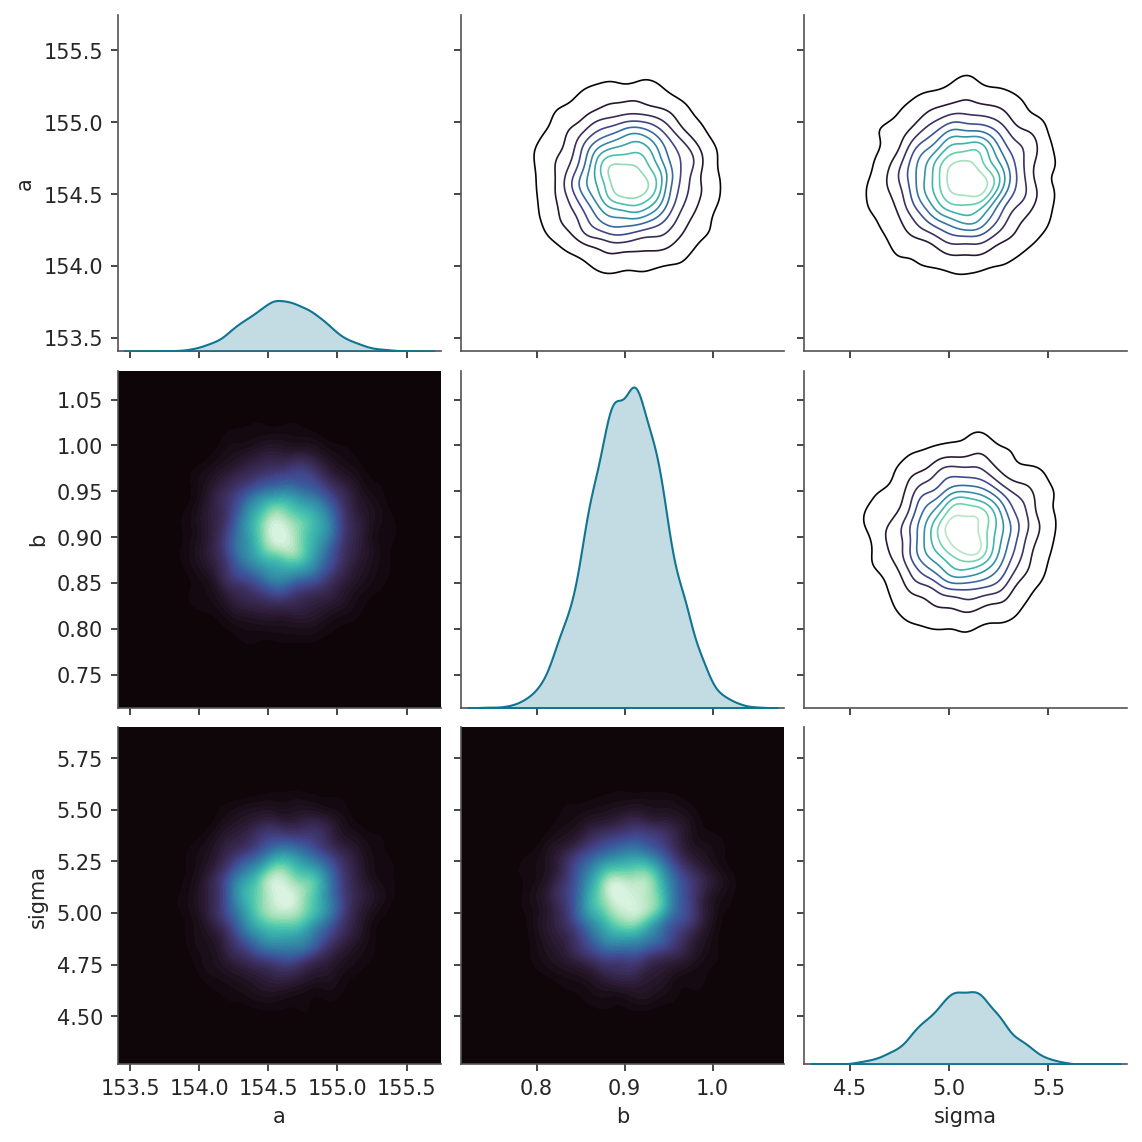

In [32]:
g = sns.PairGrid(m4_3.sample(4000))
g.map_upper(sns.kdeplot, cmap="mako", levels=10)
g.map_lower(sns.kdeplot, cmap="mako", fill=True, thresh=0, levels=50)
g.map_diag(sns.kdeplot, fill=True);

Next, we plot the model predictions against data. This helps to check whether the model is specified & fitted correctly, and interpret the posterior.

We start with plotting what mean heights should be for each weight value as per `m4_3` against data. Then we'll add more information into the plots, until we've used the entire posterior distribution.

### Code 4.46 (posterior mean height v. data)

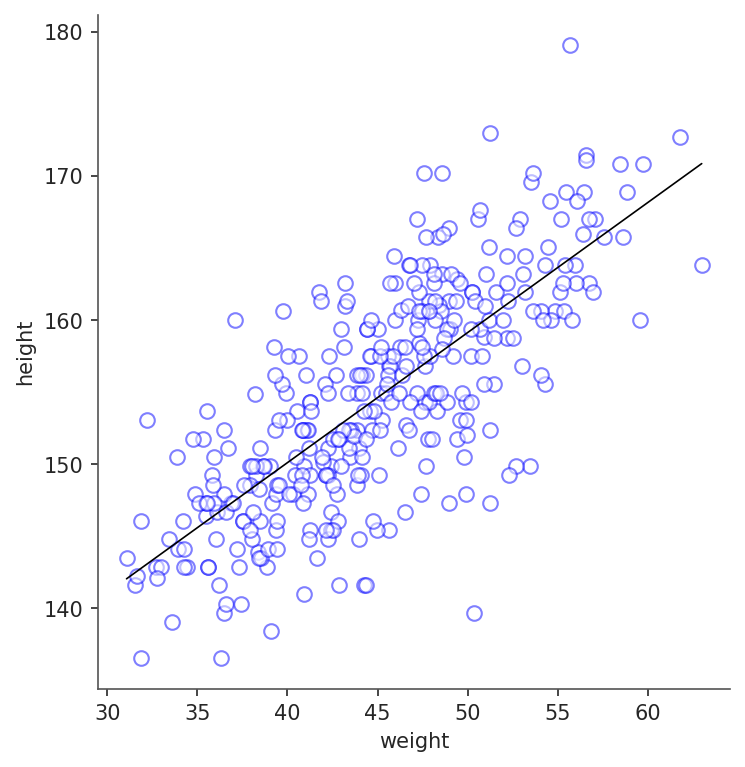

In [47]:
ax = plt.subplot(aspect=0.8)
scatter(d2.weight, d2.height, ax=ax)

post = m4_3.sample()
a_map = post.a.mean()
b_map = post.b.mean()
wbar = d2.weight.mean()
w = np.linspace(d2.weight.min(), d2.weight.max())
ax.plot(w, a_map + b_map*(w-wbar), color="k")

ax.set(xlabel="weight", ylabel="height");

Figure 4.6. Scatterplot of `Howell1` data and the posterior mean height as per `m4_3`.

### Code 4.47 (`m4_3` post sample)
To better appreciate how the posterior distribution contains lines, we work with all the samples from the model.

In [14]:
post = m4_3.sample()
post.head()

a         b     sigma
0  154.463543  0.939913  5.154681
1  155.062858  0.879040  5.028215
2  154.947514  0.907271  4.798726
3  154.743081  0.954854  5.173071
4  154.464348  0.946324  4.964486

Let's also see how adding in more data reduces the posterior uncertainties of the parameters.

### Code 4.48 (`m4_3` with 10 data points)

In [214]:
N = 10
dN = d2.iloc[:N, ]
mN = pyquap()
mN.define_objective(m4_3_obj)
mN_pars0 = {"a": "rnorm(1, 178, 20)",
            "b": "rlnorm(1, 0, 1)",
            "sigma": "runif(1, 0, 50)"}
mN.initialize(mN_pars0)
hw_data = dotdict({"h": dN.height.values, "w": dN.height.values})
mN.fit(hw_data, method="BFGS")

Optimization terminated successfully.


In [215]:
mN.precis()

mean     sd    5.5%   94.5%
a      178.44  19.71  146.78  209.87
b        0.36   0.36   -0.21    0.94
sigma  -18.68  16.95  -45.43    8.39

### Code 4.49 (plot posterior lines from the fit)

In [216]:
fig, ax = plt.subplots(2, 2, figsize=(9, 7))

scatter(dN.weight, dN.height, ax[0, 0])
ax[0, 0].set(title="N = 10")
plt.setp(ax, xlabel="weight", ylabel="height",
         xlim=[dN.weight.min() - 1, dN.weight.max() + 5], 
         ylim=[dN.height.min() - 1, dN.height.max() + 5]);

post = mN.sample(20)
wbar = d2.weight.mean()
w = np.linspace(d2.weight.min(), d2.weight.max())
for i in range(20):
    ax[0, 0].plot(w, post.a[i] + post.b[i]*(w-wbar), color="k")
plt.close()

In [223]:
N = 50
dN = d2.iloc[:N, ]
mN = pyquap()
mN.define_objective(m4_3_obj)
mN_pars0 = {"a": "rnorm(1, 178, 20)",
            "b": "rlnorm(1, 0, 1)",
            "sigma": "runif(1, 0, 50)"}
mN.initialize(mN_pars0)
hw_data = dotdict({"h": dN.height.values, "w": dN.height.values})
mN.fit(hw_data, method="BFGS")

Desired error not necessarily achieved due to precision loss.


In [224]:
mN.precis()

mean     sd    5.5%   94.5%
a      157.41  20.48  124.81  190.68
b        1.20   0.49    0.41    1.99
sigma   -1.04  70.14 -112.03  113.06

In [225]:
scatter(dN.weight, dN.height, ax[0, 1])
ax[0, 1].set(title="N = 50")
plt.setp(ax, xlabel="weight", ylabel="height",
         xlim=[dN.weight.min() - 1, dN.weight.max() + 5], 
         ylim=[dN.height.min() - 1, dN.height.max() + 5]);

post = mN.sample(20)
wbar = d2.weight.mean()
w = np.linspace(d2.weight.min(), d2.weight.max())
for i in range(20):
    ax[0, 1].plot(w, post.a[i] + post.b[i]*(w-wbar), color="k")

In [255]:
N = 150
dN = d2.iloc[:N, ]
mN = pyquap()
mN.define_objective(m4_3_obj)
mN_pars0 = {"a": "rnorm(1, 178, 20)",
            "b": "rlnorm(1, 0, 1)",
            "sigma": "runif(1, 0, 50)"}
mN.initialize(mN_pars0)
hw_data = dotdict({"h": dN.height.values, "w": dN.height.values})
mN.fit(hw_data, method="BFGS")

Optimization terminated successfully.


In [256]:
mN.precis()

mean     sd    5.5%   94.5%
a      177.80  18.86  148.03  207.77
b        0.37   0.37   -0.21    0.96
sigma  -29.99  17.86  -58.06   -1.66

In [257]:
scatter(dN.weight, dN.height, ax[1, 0])
ax[1, 0].set(title="N = 150")
plt.setp(ax, xlabel="weight", ylabel="height",
         xlim=[dN.weight.min() - 1, dN.weight.max() + 5], 
         ylim=[dN.height.min() - 1, dN.height.max() + 5]);

post = mN.sample(20)
wbar = d2.weight.mean()
w = np.linspace(d2.weight.min(), d2.weight.max())
for i in range(20):
    ax[1, 0].plot(w, post.a[i] + post.b[i]*(w-wbar), color="k")

In [274]:
N = 352
dN = d2.iloc[:N, ]
mN = pyquap()
mN.define_objective(m4_3_obj)
mN_pars0 = {"a": "rnorm(1, 178, 20)",
            "b": "rlnorm(1, 0, 1)",
            "sigma": "runif(1, 0, 50)"}
mN.initialize(mN_pars0)
hw_data = dotdict({"h": dN.height.values, "w": dN.height.values})
mN.fit(hw_data, method="BFGS")

Desired error not necessarily achieved due to precision loss.


In [275]:
mN.precis()

mean     sd    5.5%   94.5%
a      153.86  20.40  120.88  186.03
b        1.42   0.46    0.69    2.16
sigma   -2.51  22.90  -39.57   33.62

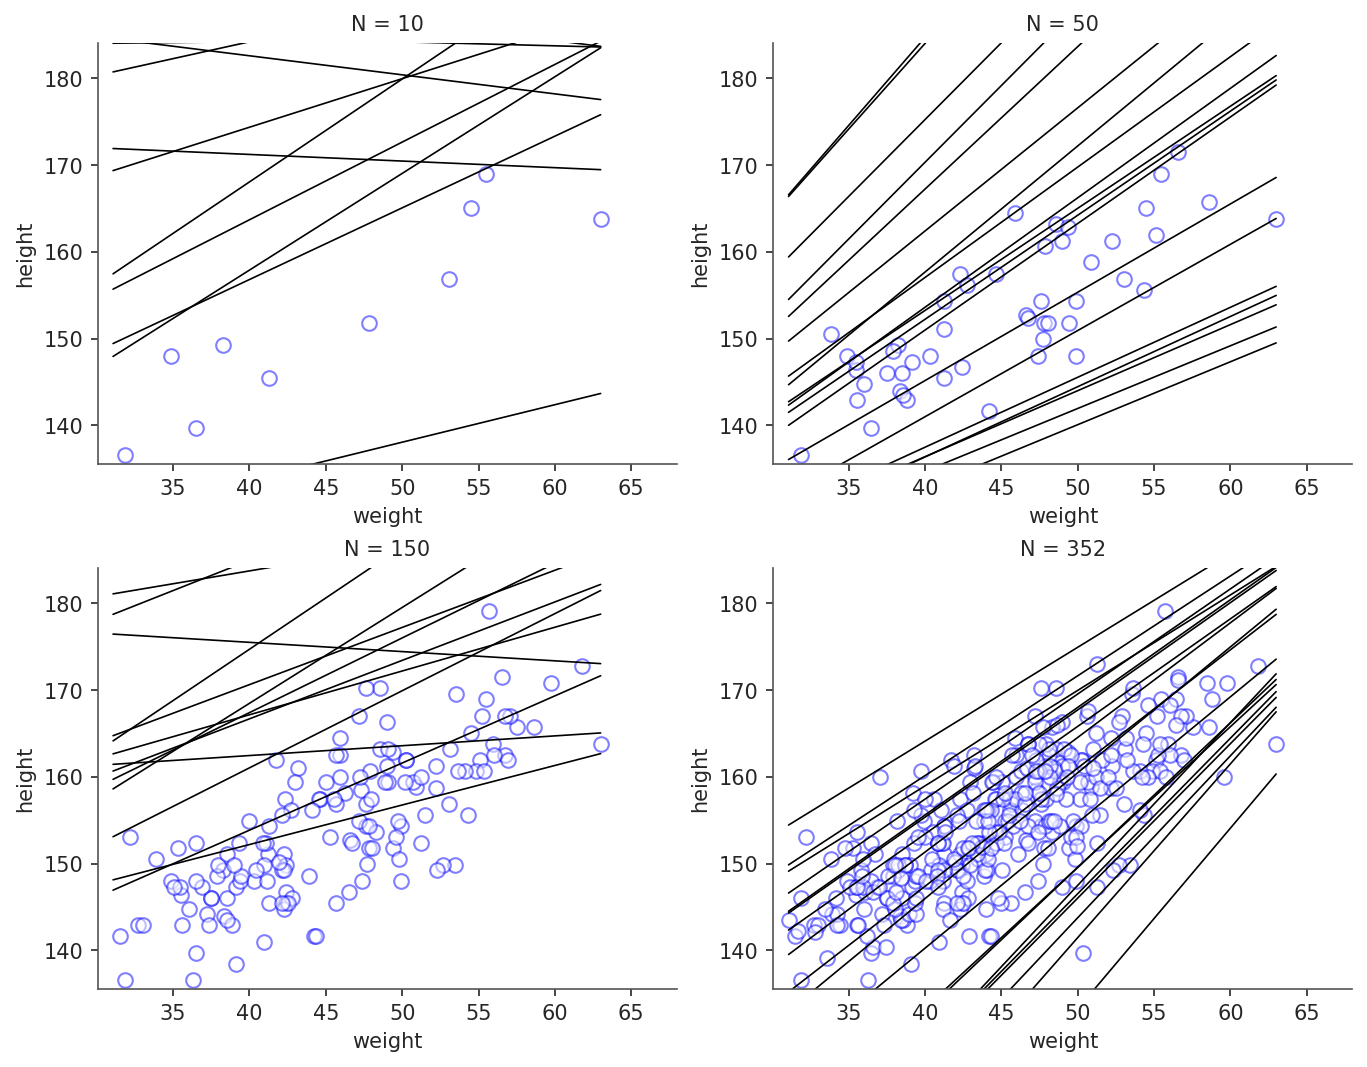

In [276]:
scatter(dN.weight, dN.height, ax[1, 1])
ax[1, 1].set(title="N = 352")
plt.setp(ax, xlabel="weight", ylabel="height",
         xlim=[dN.weight.min() - 1, dN.weight.max() + 5], 
         ylim=[dN.height.min() - 1, dN.height.max() + 5]);

post = mN.sample(20)
wbar = d2.weight.mean()
w = np.linspace(d2.weight.min(), d2.weight.max())
for i in range(20):
    ax[1, 1].plot(w, post.a[i] + post.b[i]*(w-wbar), color="k")
fig

The fit of these models from quadratic approximation shows that maximizing the log evidence is generally a difficult non-convex optimization problem.

In [64]:
%reload_ext watermark
%watermark -v -iv -p scipy,daft,pytensor -u -n -t

Last updated: Sat Apr 15 2023 08:04:31

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.12.0

scipy   : 1.10.1
daft    : 0.1.2
pytensor: 2.10.1

pandas    : 1.5.3
autograd  : 1.5
matplotlib: 3.7.1
xarray    : 2023.3.0
seaborn   : 0.12.2
arviz     : 0.15.1
pymc      : 5.2.0

